# 1. Data Cleaning & Exploratory Data Analysis

## Import Modules, Load Data & Data Review

In [1]:
# Import Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import plotly.express as px
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure & Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_style("whitegrid")

# !pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

In [2]:
# Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop related columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
        
###############################################################################

# To view summary information about the column

def first_look(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

### Loading Data

In [3]:
df0 = pd.read_excel('Online-Retail.xlsx')

In [4]:
df = df0.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


In [5]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
426372,573347,23206,LUNCH BAG APPLE DESIGN,3,2011-10-30 12:26:00,1.650,13137.000,United Kingdom
405016,C571707,23198,PANTRY MAGNETIC SHOPPING LIST,-1,2011-10-18 15:33:00,1.450,14056.000,United Kingdom
399309,571276,22496,SET OF 2 ROUND TINS DUTCH CHEESE,1,2011-10-16 12:30:00,2.950,14702.000,United Kingdom
145065,548865,84050,PINK HEART SHAPE EGG FRYING PAN,6,2011-04-04 14:09:00,1.650,14747.000,United Kingdom
177993,552211,21122,SET/10 PINK POLKADOT PARTY CANDLES,24,2011-05-06 15:01:00,1.250,12709.000,Germany


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.shape

(541909, 8)

In [8]:
from colorama import Fore, Back, Style

def first_looking(col):
    """give only column name as "col_name" not as df["col_name"]"""
    print(Back.BLACK + Fore.YELLOW, "Column name    : ", col, Style.RESET_ALL)
    print(Fore.RED + "--------------------------------", Style.RESET_ALL)
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(Fore.RED + "--------------------------------", Style.RESET_ALL)
    print("Value counts")
    print(df[col].value_counts(dropna = False))
    print(Fore.RED + "--------------------------------", Style.RESET_ALL)
    print("Descriptive statistics")
    print(df[col].describe())
    print()
    print()

In [9]:
for col in df.columns:
    first_looking(col)

 Column name    :  InvoiceNo 
-------------------------------- 
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  25900
-------------------------------- 
Value counts
573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554023        1
554022        1
554021        1
554020        1
C558901       1
Name: InvoiceNo, Length: 25900, dtype: int64
-------------------------------- 
Descriptive statistics
count     541909
unique     25900
top       573585
freq        1114
Name: InvoiceNo, dtype: int64


 Column name    :  StockCode 
-------------------------------- 
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4070
-------------------------------- 
Value counts
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64
-------------------------------- 
Descriptive statistics

### Descriptive Statistics

In [10]:
# numeric features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.000,9.552,218.081,-80995.000,1.000,3.000,10.000,80995.000
UnitPrice,541909.000,4.611,96.760,-11062.060,1.250,2.080,4.130,38970.000
CustomerID,406829.000,15287.691,1713.600,12346.000,13953.000,15152.000,16791.000,18287.000


> Standard deviation is higher than mean for `Quantity` and `UnitPrice`. Expecting extreme values. `Customer ID` is nominal type actually

In [11]:
# non-numeric features
df.describe(include="object").T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


> `InvoiceNo` and `StockCode` contain letters, that's why they are object type

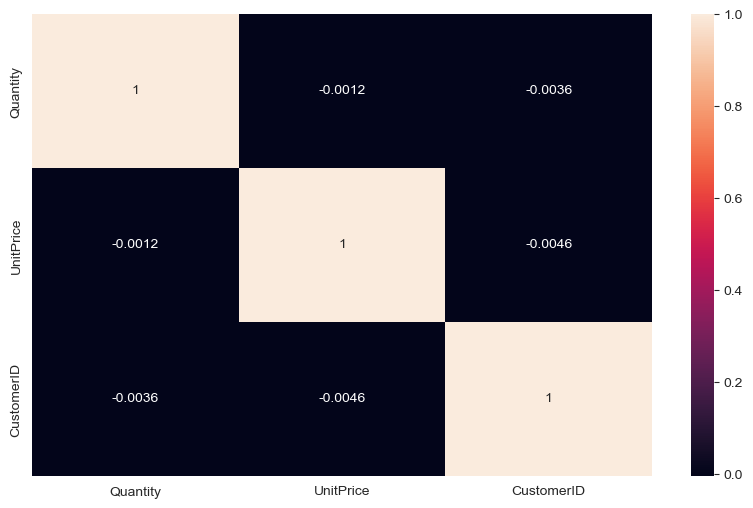

In [12]:
sns.heatmap(df.corr(), annot=True);

> No significant correlation between `UnitPrice` and `Quantity`

### i. Take a look at relationships between InvoiceNo, Quantity and UnitPrice columns.

We see that there are negative values in the Quantity and UnitPrice columns. These are possibly canceled and returned orders. Let's check it out.

In [13]:
df[df["UnitPrice"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.060,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.060,NaN,United Kingdom


In [14]:
df[df["Quantity"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.500,14527.000,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.650,15311.000,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.650,17548.000,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.830,14397.000,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.690,15498.000,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.950,15311.000,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.250,17315.000,United Kingdom


### ii. What does the letter "C" in the InvoiceNo column mean?

hint: If the invoice number starts with the letter "C", it means the order was cancelled. Or those who abandon their order.

In [15]:
df[df["InvoiceNo"].str.contains("C", na=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.500,14527.000,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.650,15311.000,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.650,17548.000,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.830,14397.000,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.690,15498.000,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.950,15311.000,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.250,17315.000,United Kingdom


When we filter canceled orders by Quantity> 0 or filter non-canceled orders by Quantity <0 nothing returns, this confirms that negative values mean the order was canceled. So lets find out how many orders were cancelled?

In [16]:
df[(df["InvoiceNo"].str.contains("C", na=False)) & (df["Quantity"] > 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [17]:
df[df["InvoiceNo"].str.contains("C", na=False)].shape[0]

9288

#### Looking deeper into why these orders were cancelled may prevent future cancellations. Now let's find out what a negative UnitPrice means.


In [18]:
df[df["InvoiceNo"].str.contains("A", na=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.060,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.060,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.060,NaN,United Kingdom


> InvoiceNo starting with "A" refers to adjustment, no CustomerID associated. Good to drop these rows.

In [19]:
#dropping rows where InvoiceNo contains "A"
drop_rows = list(df[df["InvoiceNo"].str.contains("A", na=False)].index)
df = df.drop(index = drop_rows)

### iii. Handling Missing Values

Since the customer ID's are missing, lets assume these orders were not made by the customers already in the data set because those customers already have ID's. 

We also don't want to assign these orders to those customers because this would alter the insights we draw from the data. 


In [20]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135077
Country             0
dtype: int64

In [21]:
df.isnull().sum() / df.shape[0] * 100

InvoiceNo      0.000
StockCode      0.000
Description    0.268
Quantity       0.000
InvoiceDate    0.000
UnitPrice      0.000
CustomerID    24.926
Country        0.000
dtype: float64

> `CustomerID` has 25% missing values. `Description` has minimal missing values.

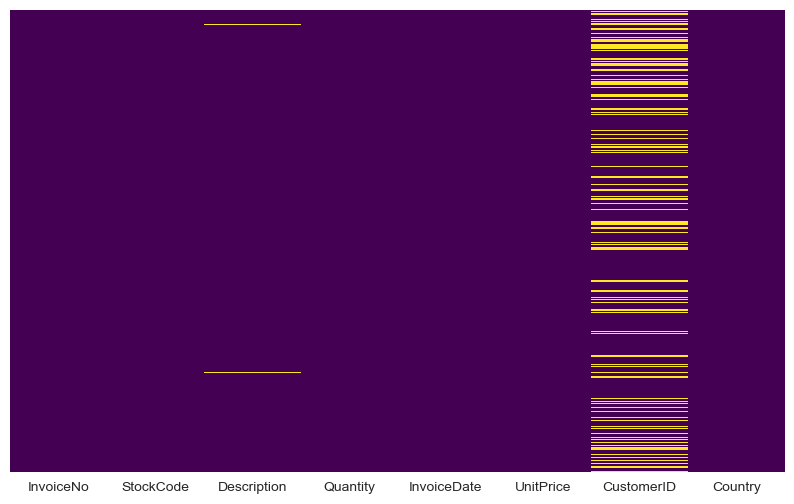

In [22]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

### iv. Clean the Data from the Noise and Missing Values

In [23]:
df.duplicated().value_counts()

False    536638
True       5268
dtype: int64

In [24]:
#Repetitive rows to be dropped as those will manipulate the analysis.
df.drop_duplicates(keep='first', inplace=True)

In [25]:
#We can drop rows where CustomerID is Nan. No way to use InvoiceNo to impute null values.
df = df[df.CustomerID.notnull()]

In [26]:
df.CustomerID.isnull().sum()

0

In [27]:
df.shape

(401604, 8)

In [28]:
df[df["InvoiceNo"].str.contains("C", na=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.500,14527.000,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.650,15311.000,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.650,17548.000,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.830,14397.000,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.690,15498.000,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.950,15311.000,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.250,17315.000,United Kingdom


> Cancelled orders are good to drop

In [29]:
#dropping rows where InvoiceNo contains "C"
df = df.drop(index = df[df["InvoiceNo"].str.contains("C", na=False)].index)

In [30]:
df.shape

(392732, 8)

In [31]:
#Export dataframe to csv file
#df.to_csv("df_cleaned.csv", index=False)

### v. Explore the Orders


1. Find the unique number of InvoiceNo  per customer

In [32]:
df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)

CustomerID
12748.000    210
14911.000    201
17841.000    124
13089.000     97
14606.000     93
            ... 
14355.000      1
13403.000      1
15488.000      1
14353.000      1
12346.000      1
Name: InvoiceNo, Length: 4339, dtype: int64

2. What's the average number of unqiue items per order or per customer?

In [33]:
mean_of_unique_items= round(df.groupby(['CustomerID',
                      'InvoiceNo']).agg({'StockCode':lambda x:x.nunique()}).groupby('CustomerID')['StockCode'].mean(),
                      1).sort_values(ascending=False)
mean_of_unique_items

CustomerID
14096.000   298.800
12378.000   219.000
16984.000   191.000
12688.000   171.000
15464.000   155.000
              ...  
16881.000     1.000
16953.000     1.000
16990.000     1.000
16998.000     1.000
15299.000     1.000
Name: StockCode, Length: 4339, dtype: float64

3. Let's see how this compares to the number of unique products per customer.

In [34]:
# number of unique products per customer
num_of_unique_product= pd.DataFrame(df.groupby('CustomerID').StockCode.nunique()).rename(columns={'StockCode':'num_of_unique_product'})
num_of_unique_product

,num_of_unique_product
CustomerID,
12346.000,1
12347.000,103
12348.000,22
12349.000,73
12350.000,17
...,...
18280.000,10
18281.000,7
18282.000,12


In [35]:
# number of unique orders per customer
num_of_unique_order = pd.DataFrame(df.groupby('CustomerID').InvoiceNo.nunique()).rename(columns={'InvoiceNo':'num_of_unique_orders'})
num_of_unique_order

,num_of_unique_orders
CustomerID,
12346.000,1
12347.000,7
12348.000,4
12349.000,1
12350.000,1
...,...
18280.000,1
18281.000,1
18282.000,2


In [36]:
df_customer = num_of_unique_order.merge(num_of_unique_product, on='CustomerID')
df_customer

,num_of_unique_orders,num_of_unique_product
CustomerID,,
12346.000,1,1
12347.000,7,103
12348.000,4,22
12349.000,1,73
12350.000,1,17
...,...,...
18280.000,1,10
18281.000,1,7
18282.000,2,12


### vi. Explore Customers by Country

1. What's the total revenue per country?

In [37]:
df['Total'] = df['UnitPrice']*df['Quantity']

In [38]:
df2=pd.DataFrame(df.groupby('Country').Total.sum().apply(lambda x: round(x,2))).sort_values('Total',ascending=False)
df2['percentage_of_Total']=round(df2.Total/df2.Total.sum()*100,2)
df2

,Total,percentage_of_Total
Country,,
United Kingdom,7285024.640,81.970
Netherlands,285446.340,3.210
EIRE,265262.460,2.980
Germany,228678.400,2.570
France,208934.310,2.350
Australia,138453.810,1.560
Spain,61558.560,0.690
Switzerland,56443.950,0.640
Belgium,41196.340,0.460


2. Visualize number of customer per country

In [39]:
df2['customer_count']=df.groupby('Country').CustomerID.nunique()
df2['customer_rate']=round(df2.customer_count/df2.customer_count.sum()*100,2)
df2.head(5)

,Total,percentage_of_Total,customer_count,customer_rate
Country,,,,
United Kingdom,7285024.640,81.970,3921,90.200
Netherlands,285446.340,3.210,9,0.210
EIRE,265262.460,2.980,3,0.070
Germany,228678.400,2.570,94,2.160
France,208934.310,2.350,87,2.000


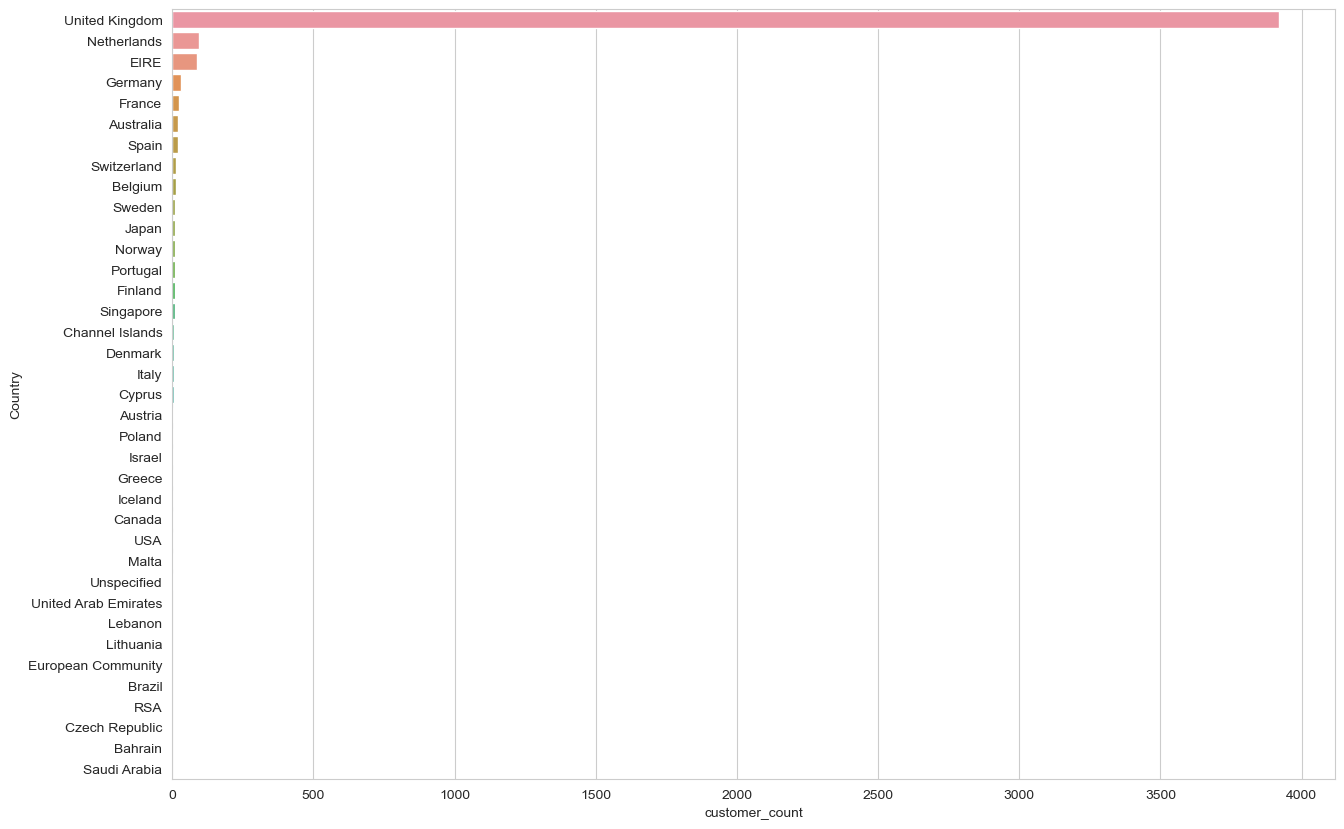

In [40]:
plt.figure(figsize=(15,10))
sns.barplot(y=df2.index, x=df2.customer_count.sort_values(ascending=False));

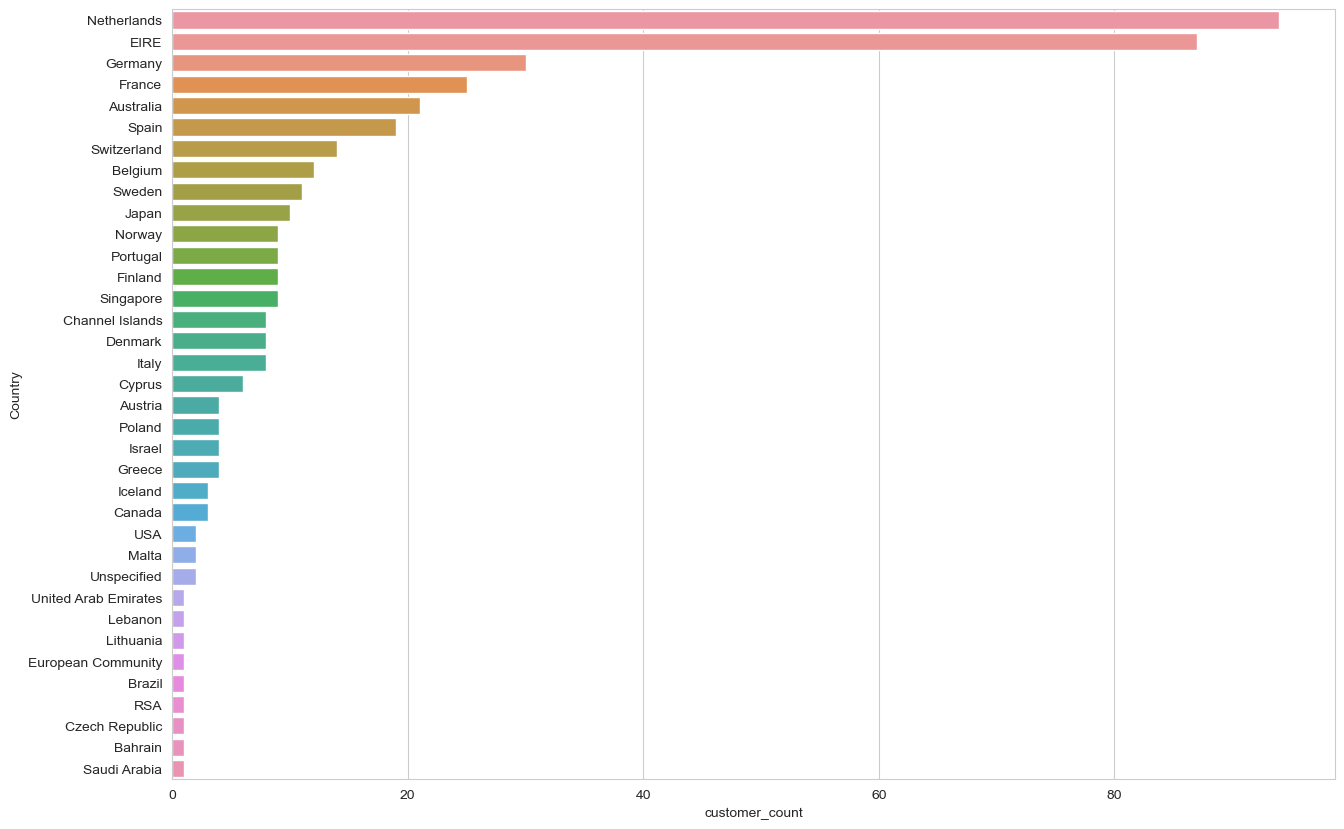

In [41]:
# check the plot without United Kingdom
plt.figure(figsize=(15,10))
sns.barplot(y=df2.iloc[1:].index, x=df2.iloc[1:].customer_count.sort_values(ascending=False));

3. Visualize total revenue per country

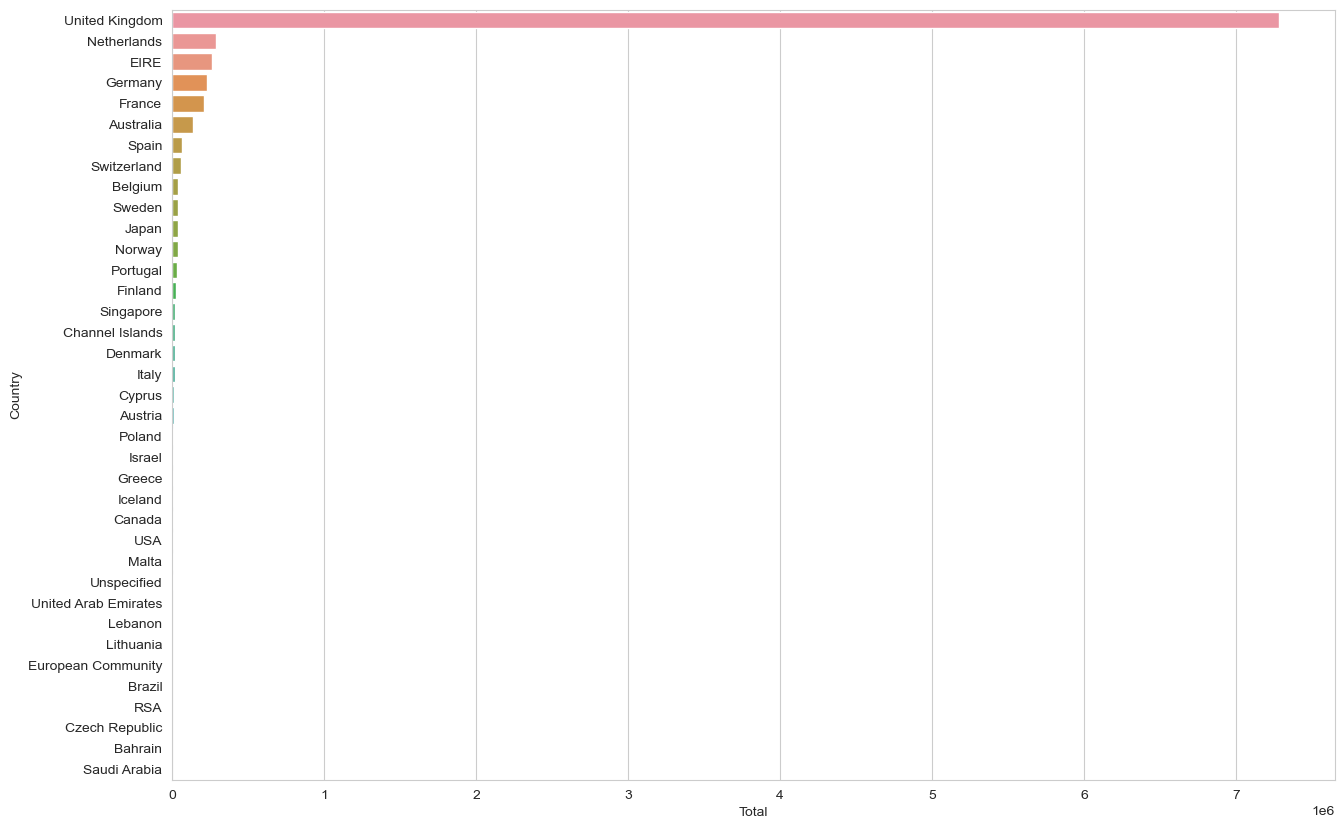

In [42]:
plt.figure(figsize=(15,10))
sns.barplot(y=df2.index, x=df2.Total.sort_values(ascending=False));

#### The UK not only has the most sales revenue, but also the most customers. Since the majority of this data set contains orders from the UK, we can explore the UK market further by finding out what products the customers buy together and any other buying behaviors to improve our sales and targeting strategy.

### vii. Explore the UK Market


1. Create df_uk DataFrame

In [43]:
df_uk=df[df.Country=='United Kingdom']
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


2. What are the most popular products that are bought in the UK?

In [44]:
pd.DataFrame(df_uk.StockCode.value_counts().head(10))

,StockCode
85123A,1936
85099B,1461
22423,1417
84879,1320
47566,1301
20725,1135
20727,1022
22720,1013
23203,993
22383,977


In [45]:
#Export dataframe to csv file
# df_uk.to_csv("df_uk.csv", index=False)

### We will continue analyzing the UK transactions with customer segmentation.

# 2. RFM Analysis

In the age of the internet and e-commerce, companies that do not expand their businesses online or utilize digital tools to reach their customers will run into issues like scalability and a lack of digital precsence. An important marketing strategy e-commerce businesses use for analyzing and predicting customer value is customer segmentation. Customer data is used to sort customers into group based on their behaviors and preferences.

**[RFM](https://www.putler.com/rfm-analysis/) (Recency, Frequency, Monetary) Analysis** is a customer segmentation technique for analyzing customer value based on past buying behavior. RFM analysis was first used by the direct mail industry more than four decades ago, yet it is still an effective way to optimize your marketing.
<br>
<br>
Our goal in this Notebook is to cluster the customers in our data set to:
 - Recognize who are our most valuable customers
 - Increase revenue
 - Increase customer retention
 - Learn more about the trends and behaviors of our customers
 - Define customers that are at risk

We will start with **RFM Analysis** and then compliment our findings with predictive analysis using **K-Means Clustering Algorithms.**

- RECENCY (R): Time since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total monetary value




Benefits of RFM Analysis

- Increased customer retention
- Increased response rate
- Increased conversion rate
- Increased revenue

RFM Analysis answers the following questions:
 - Who are our best customers?
 - Who has the potential to be converted into more profitable customers?
 - Which customers do we need to retain?
 - Which group of customers is most likely to respond to our marketing campaign?
 

### i. Import Libraries

### ii. Review df_uk DataFrame

In [46]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349227 non-null  object        
 1   StockCode    349227 non-null  object        
 2   Description  349227 non-null  object        
 3   Quantity     349227 non-null  int64         
 4   InvoiceDate  349227 non-null  datetime64[ns]
 5   UnitPrice    349227 non-null  float64       
 6   CustomerID   349227 non-null  float64       
 7   Country      349227 non-null  object        
 8   Total        349227 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 26.6+ MB


### iii. Recency: Days since last purchase
To calculate the recency values, follow these steps in order:

1. To calculate recency, we need to choose a date as a point of reference to evaluate how many days ago was the customer's last purchase.
2. Create a new column called Date which contains the invoice date without the timestamp
3. Group by CustomerID and check the last date of purchase
4. Calculate the days since last purchase
5. Drop Last_Purchase_Date since we don't need it anymore
6. Plot RFM distributions

1. Choose a date as a point of reference to evaluate how many days ago was the customer's last purchase.

In [47]:
#last purchase date
df_uk["InvoiceDate"].max()

Timestamp('2011-12-09 12:49:00')

2. Create a new column called Date which contains the invoice date without the timestamp

In [48]:
df_uk["Date"] = df_uk["InvoiceDate"].dt.date
df_uk["Date"]

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541889    2011-12-09
541890    2011-12-09
541891    2011-12-09
541892    2011-12-09
541893    2011-12-09
Name: Date, Length: 349227, dtype: object

3. Group by CustomerID and check the last date of purchase

In [49]:
df_uk.groupby("CustomerID", as_index=False)["Date"].max()

,CustomerID,Date
0,12346.000,2011-01-18
1,12747.000,2011-12-07
2,12748.000,2011-12-09
3,12749.000,2011-12-06
4,12820.000,2011-12-06
...,...,...
3916,18280.000,2011-03-07
3917,18281.000,2011-06-12
3918,18282.000,2011-12-02
3919,18283.000,2011-12-06


4. Calculate the days since last purchase

In [50]:
#Calculating Recency
recency_df = df_uk.groupby(by='CustomerID',as_index=False)['Date'].max()
recency_df.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = recency_df['LastPurchaseDate'].max()
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.000,2011-01-18,325
1,12747.000,2011-12-07,2
2,12748.000,2011-12-09,0
3,12749.000,2011-12-06,3
4,12820.000,2011-12-06,3


5. Drop Last_Purchase_Date since we don't need it anymore

In [51]:
recency_df.drop("LastPurchaseDate", axis=1, inplace=True)

6. Plot RFM distributions

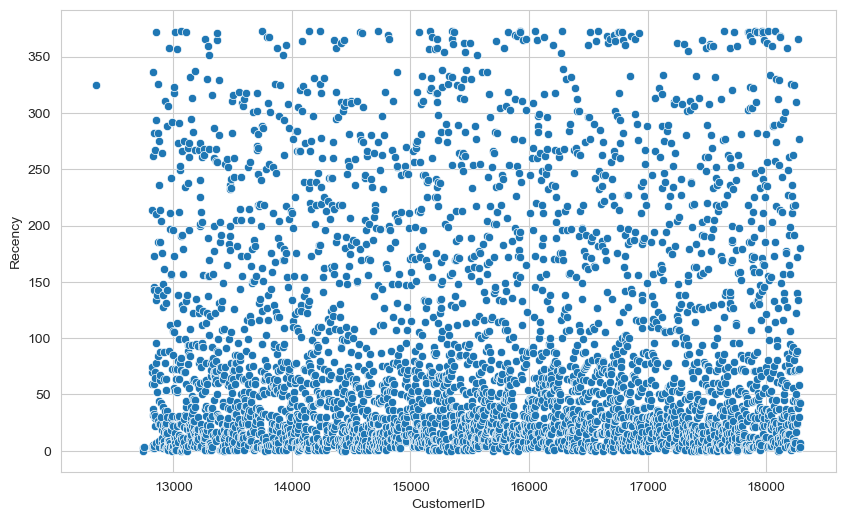

In [52]:
sns.scatterplot(data=recency_df, x="CustomerID", y="Recency");

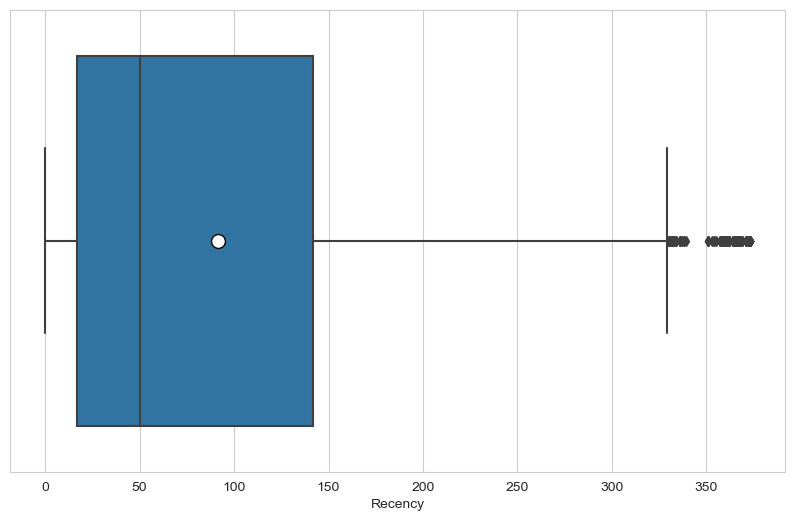

In [53]:
sns.boxplot(data=recency_df, 
            x="Recency",
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"});

### iv. Frequency: Number of purchases

To calculate how many times a customer purchased something, we need to count how many invoices each customer has. To calculate the frequency values, follow these steps in order:

1. Make a copy of df_uk and drop duplicates

In [54]:
df_uk2 = df_uk.copy().drop_duplicates()
df_uk2.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Date
421087,572918,85035A,GARDENIA 3 WICK MORRIS BOXED CANDLE,2,2011-10-26 16:43:00,1.250,14379.000,United Kingdom,2.500,2011-10-26
517260,580048,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2011-12-01 12:53:00,3.250,12748.000,United Kingdom,3.250,2011-12-01


2. Calculate the frequency of purchases

In [55]:
#Calculating Frequency with purchases

frequency_df = df_uk2.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].nunique()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.000,1
1,12747.000,11
2,12748.000,210
3,12749.000,5
4,12820.000,4


3. Plot RFM distributions

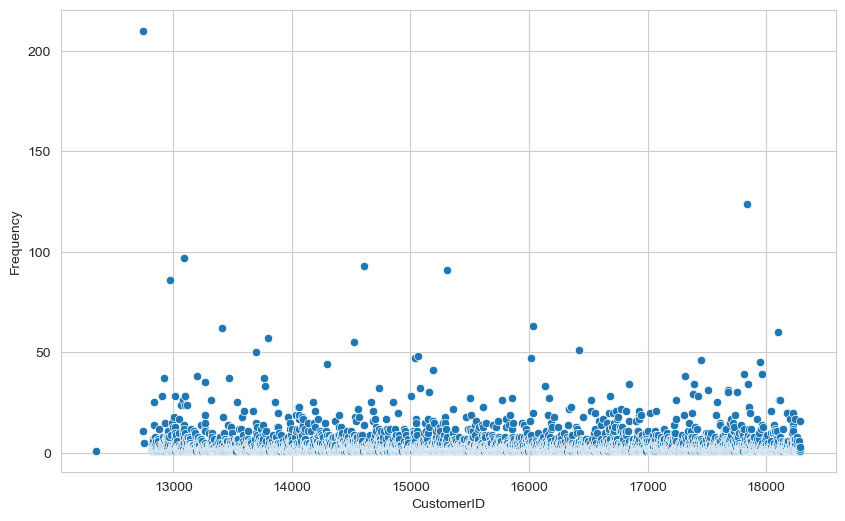

In [56]:
sns.scatterplot(data=frequency_df, x="CustomerID", y="Frequency");

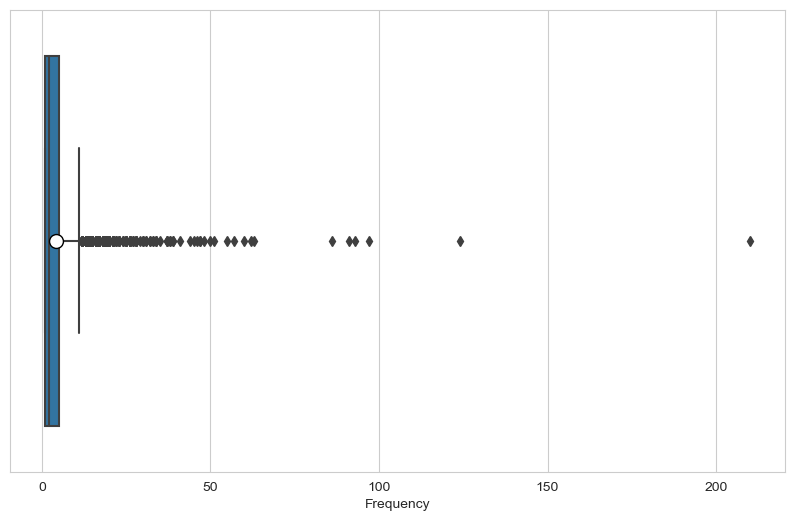

In [57]:
sns.boxplot(data=frequency_df, 
            x="Frequency",
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"});

### v. Monetary: Total amount of money spent

The monetary value is calculated by adding together the cost of the customers' purchases.


1. Calculate sum total cost by customers and named "Monetary"

In [58]:
#Calculating Monetary
monetary_df = df_uk.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.000,77183.600
1,12747.000,4196.010
2,12748.000,33053.190
3,12749.000,4090.880
4,12820.000,942.340


2. Plot RFM distributions

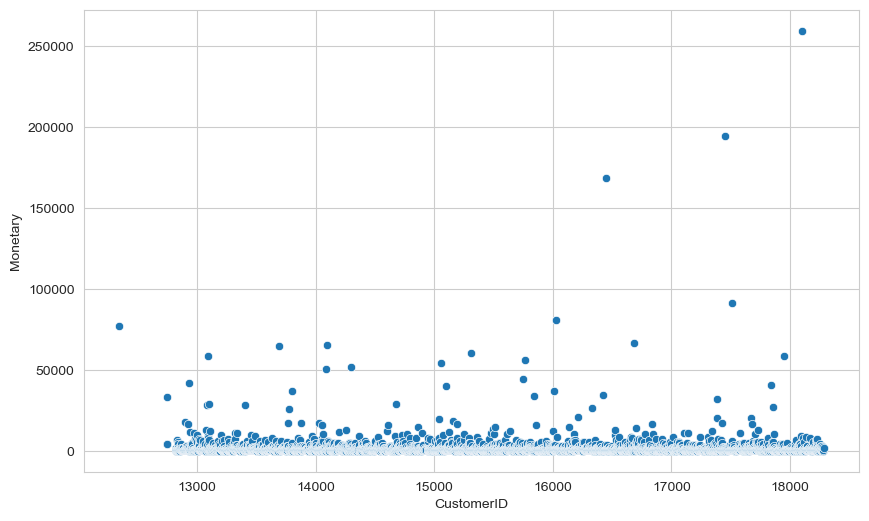

In [59]:
sns.scatterplot(data=monetary_df, x="CustomerID", y="Monetary");

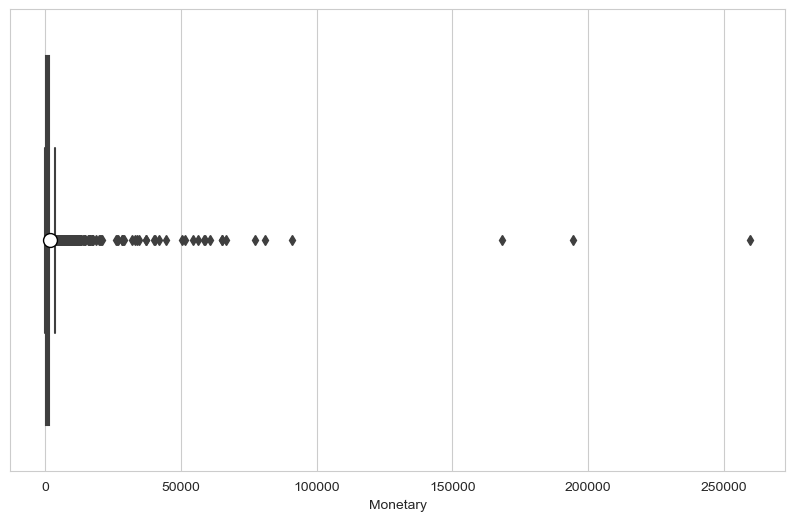

In [60]:
sns.boxplot(data=monetary_df, 
            x="Monetary",
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"});

### vi. Create RFM Table
Merge the recency, frequency and motetary dataframes

In [61]:
#Merging all three columns in one dataframe
rf_df = recency_df.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.000,325,1,77183.600
1,12747.000,2,11,4196.010
2,12748.000,0,210,33053.190
3,12749.000,3,5,4090.880
4,12820.000,3,4,942.340


# 3. Customer Segmentation with RFM Scores

Businesses have this ever-lasting urge to understand their customers. The better you understand the customer, the better you serve them, and the higher the financial gain you receive from that customer. Since the dawn of trade, this process of understanding customers for a strategic gain has been there practiced and this task is known majorly as [Customer Segmentation](https://clevertap.com/blog/rfm-analysis/).
Well as the name suggests, Customer Segmentation could segment customers according to their precise needs. Some of the common ways of segmenting customers are based on their Recency-Frequency-Monatory values, their demographics like gender, region, country, etc, and some of their business-crafted scores. You will use Recency-Frequency-Monatory values for this case.

In this section, you will create an RFM Segmentation Table where you segment your customers by using the RFM table. For example, you can label the best customer as "Big Spenders" and the lost customer as "Lost Customer".

## Calculate RFM Scoring

The simplest way to create customer segments from an RFM model is by using **Quartiles**. We will assign a score from 1 to 4 to each category (Recency, Frequency, and Monetary) with 4 being the highest/best value. The final RFM score is calculated by combining all RFM values. For Customer Segmentation, you will use the df_rfm data set resulting from the RFM analysis.
<br>
<br>
**Note**: Data can be assigned into more groups for better granularity, but we will use 4 in this case.

1. Divide the df_rfm into quarters

### i. Creating the RFM Segmentation Table


1. Create two functions, one for Recency and one for Frequency and Monetary. For Recency, customers in the first quarter should be scored as 4, this represents the highest Recency value. Conversely, for Frequency and Monetary, customers in the last quarter should be scored as 4, representing the highest Frequency and Monetary values.

In [62]:
#Ranking Customers based on their recency, frequency, and monetary score
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.000,325,1,77183.600,3.647,17.240,17.240
1,12747.000,2,11,4196.010,96.084,92.744,92.744
2,12748.000,0,210,33053.190,100.000,100.000,100.000
3,12749.000,3,5,4090.880,93.960,77.072,77.072
4,12820.000,3,4,942.340,93.960,69.829,69.829


**Calculating RFM score**

RFM score is calculated based upon normalized recency, frequency, monetary ranks. 

Based upon this score we group the customers. Here we rate them on a scale of 5. 

We assign weights to scores such as:
- Monetary value is the most important (0.60 coefficient)
- Frequency is the next important (0.25 coefficient)
- Recency is the third important (0.15 coefficient)

Formula used for calculating rfm score is : `0.15 * Recency score + 0.25 * Frequency score + 0.60 * Monetary score`

In [63]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm'] + 0.25*rfm_df['F_rank_norm'] + 0.60*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['CustomerID', 'RFM_Score']].head()

,CustomerID,RFM_Score
0,12346.000,0.760
1,12747.000,4.660
2,12748.000,5.000
3,12749.000,3.980
4,12820.000,3.670


**Rating Customer based upon the RFM score**

- rfm score > 4.5       : Top Customer
- 4.5 > rfm score > 4   : High Value Customer
- 4 > rfm score > 3     : Medium value customer
- 3 > rfm score > 1.6   : Low-value customer
- rfm score < 1.6       :Lost Customer

In [64]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >	4.5, "Top Customers",
									(np.where(rfm_df['RFM_Score'] > 4,"High value Customer",
									(np.where(rfm_df['RFM_Score'] > 3,"Medium Value Customer",
							        np.where(rfm_df['RFM_Score'] > 1.6,	'Low Value Customers', 'Lost Customers'))))))
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerID,RFM_Score,Customer_segment
0,12346.000,0.760,Lost Customers
1,12747.000,4.660,Top Customers
2,12748.000,5.000,Top Customers
3,12749.000,3.980,Medium Value Customer
4,12820.000,3.670,Medium Value Customer
5,12821.000,0.850,Lost Customers
6,12822.000,2.170,Low Value Customers
7,12823.000,3.560,Medium Value Customer
8,12824.000,1.070,Lost Customers
9,12826.000,4.360,High value Customer


In [65]:
#Exporting RFM dataframe to csv file
# rfm_df.to_csv("df_rfm_uk.csv", index=False)

2. Score customers from 1 to 4 by applying the functions you have created. Also create separate score column for each value. 

3. Now that scored each customer, you'll combine the scores for segmentation.

4. Define rfm_level function that tags customers by using RFM_Scrores and Create a new variable RFM_Level

5. Calculate average values for each RFM_Level, and return a size of each segment 

## Plot RFM Segments

1. Create your plot and resize it.

In [66]:
rfm_df.Customer_segment.value_counts().index

Index(['Lost Customers', 'Low Value Customers', 'Medium Value Customer',
       'High value Customer', 'Top Customers'],
      dtype='object')

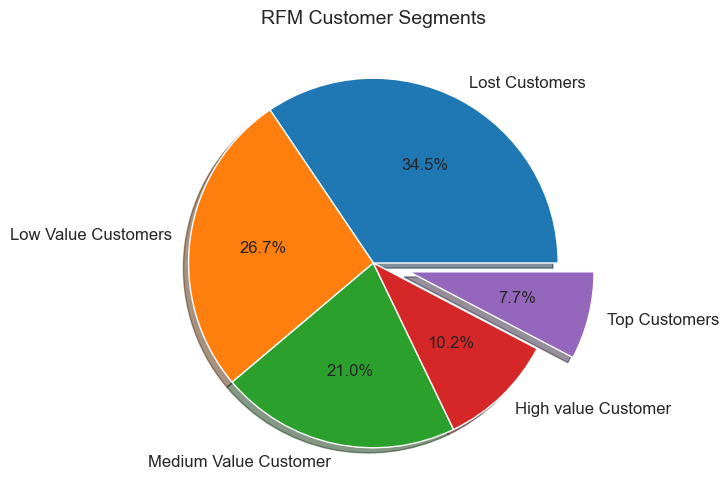

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(x=rfm_df.Customer_segment.value_counts().values, 
       labels=rfm_df.Customer_segment.value_counts().index, 
       autopct='%.1f%%',
       explode=[0,0,0,0,0.2],
       textprops={'fontsize': 12},
       shadow=True
       )
plt.title("RFM Customer Segments", fontdict = {'fontsize': 14})
plt.show()

Using customer segmentation categories found [here](http://www.blastam.com/blog/rfm-analysis-boosts-sales). We can formulate different marketing strategies and approaches for customer engagement for each type of customer.

Note: The author in the article scores 1 as the highest and 4 as the lowest

2. How many customers do we have in each segment?

In [68]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3921 entries, 0 to 3920
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        3921 non-null   float64
 1   Recency           3921 non-null   int64  
 2   Frequency         3921 non-null   int64  
 3   Monetary          3921 non-null   float64
 4   R_rank_norm       3921 non-null   float64
 5   F_rank_norm       3921 non-null   float64
 6   M_rank_norm       3921 non-null   float64
 7   RFM_Score         3921 non-null   float64
 8   Customer_segment  3921 non-null   object 
dtypes: float64(6), int64(2), object(1)
memory usage: 306.3+ KB


In [69]:
rfm_df.Customer_segment.value_counts().index

Index(['Lost Customers', 'Low Value Customers', 'Medium Value Customer',
       'High value Customer', 'Top Customers'],
      dtype='object')

In [70]:
rfm_df.sample(3)

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
1465,14886.000,252,1,364.800,11.200,17.240,17.240,0.820,Lost Customers
2826,16759.000,7,3,789.790,88.770,59.420,59.420,3.190,Medium Value Customer
3383,17545.000,43,3,642.320,53.950,59.420,59.420,2.930,Low Value Customers


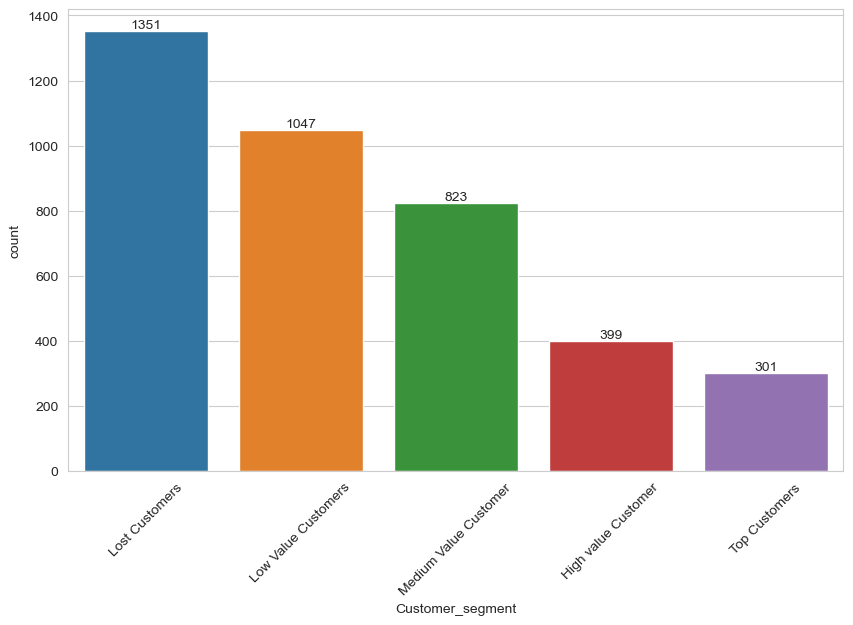

In [71]:
fig, ax = plt.subplots()

ax = sns.countplot(rfm_df.Customer_segment, order=rfm_df.Customer_segment.value_counts().index)

plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container);

# RFM with global customers

In [72]:
df_global = pd.read_csv("df_cleaned.csv")
df_global.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


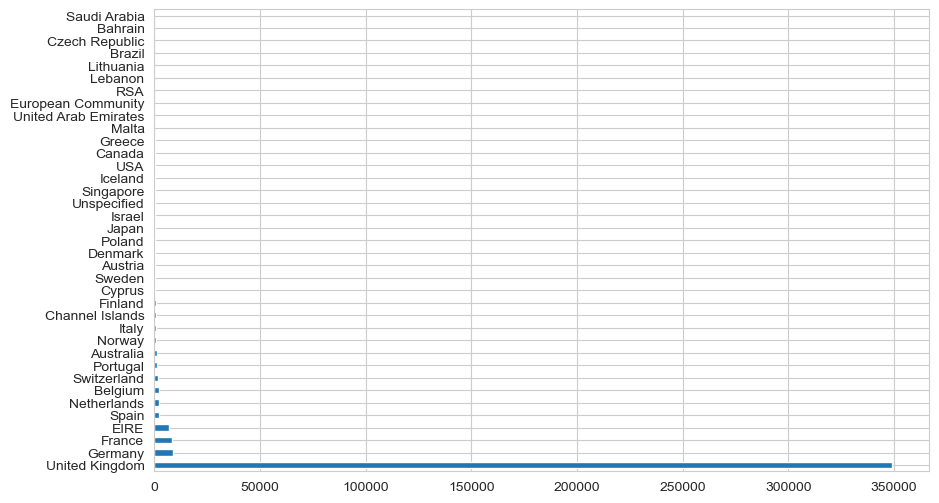

In [73]:
df_global.Country.value_counts().plot(kind='barh');

In [74]:
#last purchase date
df_global["InvoiceDate"].max()

'2011-12-09 12:50:00'

In [75]:
df_global["Date"] = pd.to_datetime(df_global["InvoiceDate"]).dt.date
df_global["Date"]

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
392727    2011-12-09
392728    2011-12-09
392729    2011-12-09
392730    2011-12-09
392731    2011-12-09
Name: Date, Length: 392732, dtype: object

In [76]:
df_global["Total"] = df_global["Quantity"] * df_global["UnitPrice"]

In [77]:
df_global.sample(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total
370045,579167,23406,HOME SWEET HOME KEY HOLDER,1,2011-11-28 14:06:00,6.250,16800.000,United Kingdom,2011-11-28,6.250
392588,581574,22074,6 RIBBONS SHIMMERING PINKS,12,2011-12-09 12:09:00,0.390,12526.000,Germany,2011-12-09,4.680
134733,553919,21922,UNION STRIPE WITH FRINGE HAMMOCK,12,2011-05-20 08:41:00,6.950,17416.000,United Kingdom,2011-05-20,83.400
222445,564733,22110,BIRD HOUSE HOT WATER BOTTLE,4,2011-08-28 13:18:00,2.550,17841.000,United Kingdom,2011-08-28,10.200
87656,547805,84828,JUNGLE POPSICLES ICE LOLLY MOULDS,12,2011-03-25 13:35:00,1.250,13327.000,United Kingdom,2011-03-25,15.000
105403,550149,22748,POPPY'S PLAYHOUSE KITCHEN,1,2011-04-14 14:37:00,2.100,13069.000,United Kingdom,2011-04-14,2.100
152974,556284,22720,SET OF 3 CAKE TINS PANTRY DESIGN,3,2011-06-10 08:54:00,4.950,17115.000,United Kingdom,2011-06-10,14.850
190379,561036,23316,RED REFECTORY CLOCK,1,2011-07-24 11:54:00,9.950,13137.000,United Kingdom,2011-07-24,9.950
77883,546646,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2011-03-15 13:49:00,1.250,13716.000,United Kingdom,2011-03-15,2.500
40315,541884,21188,3D HEARTS HONEYCOMB PAPER GARLAND,12,2011-01-24 11:12:00,2.950,14782.000,United Kingdom,2011-01-24,35.400


## Recency for global customers

In [78]:
#Calculating Recency for global customers
df_recency_global = df_global.groupby(by='CustomerID',as_index=False)['Date'].max()
df_recency_global.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = df_recency_global['LastPurchaseDate'].max()
df_recency_global['Recency'] = df_recency_global['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency_global.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.000,2011-01-18,325
1,12347.000,2011-12-07,2
2,12348.000,2011-09-25,75
3,12349.000,2011-11-21,18
4,12350.000,2011-02-02,310


In [79]:
df_recency_global.shape

(4339, 3)

In [80]:
recency_df.shape

(3921, 2)

In [81]:
df_recency_global.drop("LastPurchaseDate", axis=1, inplace=True)

## Frequency for global customers

In [82]:
#Calculating Frequency with purchases for global customers

df_frequency_global = df_global.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].nunique()
df_frequency_global.columns = ['CustomerID', 'Frequency']
df_frequency_global.head()

,CustomerID,Frequency
0,12346.000,1
1,12347.000,7
2,12348.000,4
3,12349.000,1
4,12350.000,1


In [83]:
df_frequency_global.shape

(4339, 2)

In [84]:
frequency_df.shape

(3921, 2)

## Monetary for global customers

In [85]:
#Calculating Monetary for global customers
df_monetary_global = df_global.groupby(by='CustomerID', as_index=False)['Total'].sum()
df_monetary_global.columns = ['CustomerID', 'Monetary']
df_monetary_global.head()

,CustomerID,Monetary
0,12346.000,77183.600
1,12347.000,4310.000
2,12348.000,1797.240
3,12349.000,1757.550
4,12350.000,334.400


In [86]:
df_monetary_global.shape

(4339, 2)

In [87]:
monetary_df.shape

(3921, 2)

## RFM Table - Global

In [88]:
#Merging all three columns in one dataframe
rf_df_global = df_recency_global.merge(df_frequency_global, on='CustomerID')
rfm_df_global = rf_df_global.merge(df_monetary_global, on='CustomerID')
rfm_df_global.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.000,325,1,77183.600
1,12347.000,2,7,4310.000
2,12348.000,75,4,1797.240
3,12349.000,18,1,1757.550
4,12350.000,310,1,334.400


In [89]:
rfm_df_global.shape

(4339, 4)

In [90]:
rfm_df.shape

(3921, 9)

## Customer Segmentation with RFM Scores - Global

In [91]:
#Ranking Customers based on their recency, frequency, and monetary score
rfm_df_global['R_rank'] = rfm_df_global['Recency'].rank(ascending=False)
rfm_df_global['F_rank'] = rfm_df_global['Frequency'].rank(ascending=True)
rfm_df_global['M_rank'] = rfm_df_global['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df_global['R_rank_norm'] = (rfm_df_global['R_rank']/rfm_df_global['R_rank'].max())*100
rfm_df_global['F_rank_norm'] = (rfm_df_global['F_rank']/rfm_df_global['F_rank'].max())*100
rfm_df_global['M_rank_norm'] = (rfm_df_global['F_rank']/rfm_df_global['M_rank'].max())*100

rfm_df_global.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df_global.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.000,325,1,77183.600,3.760,17.227,17.227
1,12347.000,2,7,4310.000,96.171,85.527,85.527
2,12348.000,75,4,1797.240,38.084,69.855,69.855
3,12349.000,18,1,1757.550,74.260,17.227,17.227
4,12350.000,310,1,334.400,5.264,17.227,17.227


In [92]:
rfm_df_global['RFM_Score'] = 0.15*rfm_df_global['R_rank_norm'] + 0.25*rfm_df_global['F_rank_norm'] + 0.60*rfm_df_global['M_rank_norm']
rfm_df_global['RFM_Score'] *= 0.05
rfm_df_global = rfm_df_global.round(2)
rfm_df_global[['CustomerID', 'RFM_Score']].head()

,CustomerID,RFM_Score
0,12346.000,0.760
1,12347.000,4.360
2,12348.000,3.250
3,12349.000,1.290
4,12350.000,0.770


In [93]:
rfm_df_global["Customer_segment"] = np.where(rfm_df_global['RFM_Score'] >	4.5, "Top Customers",
									(np.where(rfm_df_global['RFM_Score'] > 4,"High value Customer",
									(np.where(rfm_df_global['RFM_Score'] > 3,"Medium Value Customer",
							        np.where(rfm_df_global['RFM_Score'] > 1.6,	'Low Value Customers', 'Lost Customers'))))))
rfm_df_global[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerID,RFM_Score,Customer_segment
0,12346.000,0.760,Lost Customers
1,12347.000,4.360,High value Customer
2,12348.000,3.250,Medium Value Customer
3,12349.000,1.290,Lost Customers
4,12350.000,0.770,Lost Customers
5,12352.000,4.190,High value Customer
6,12353.000,0.860,Lost Customers
7,12354.000,0.840,Lost Customers
8,12355.000,0.850,Lost Customers
9,12356.000,3.060,Medium Value Customer


In [94]:
#Exporting RFM dataframe to csv file
# rfm_df_global.to_csv("df_rfm_global.csv", index=False)

In [95]:
rfm_df_global.sample(20)

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
3186,16697.000,241,1,112.750,12.610,17.230,17.230,0.830,Lost Customers
3452,17053.000,130,1,498.480,26.690,17.230,17.230,0.930,Lost Customers
532,13045.000,99,1,305.280,31.710,17.230,17.230,0.970,Lost Customers
2204,15347.000,366,1,201.600,1.380,17.230,17.230,0.740,Lost Customers
2769,16121.000,57,2,854.660,46.900,44.070,44.070,2.220,Low Value Customers
2918,16326.000,5,14,3039.220,90.220,95.400,95.400,4.730,Top Customers
835,13467.000,10,2,1071.910,83.640,44.070,44.070,2.500,Low Value Customers
2970,16394.000,56,5,1555.340,47.480,77.110,77.110,3.630,Medium Value Customer
3209,16726.000,26,5,1358.740,65.510,77.110,77.110,3.770,Medium Value Customer
2282,15453.000,1,7,1371.770,98.400,85.530,85.530,4.370,High value Customer


## Plot RFM Segments - Global

In [96]:
rfm_df_global.Customer_segment.value_counts().index

Index(['Lost Customers', 'Low Value Customers', 'Medium Value Customer',
       'High value Customer', 'Top Customers'],
      dtype='object')

In [97]:
rfm_df_global.Customer_segment.value_counts()

Lost Customers           1494
Low Value Customers      1154
Medium Value Customer     918
High value Customer       441
Top Customers             332
Name: Customer_segment, dtype: int64

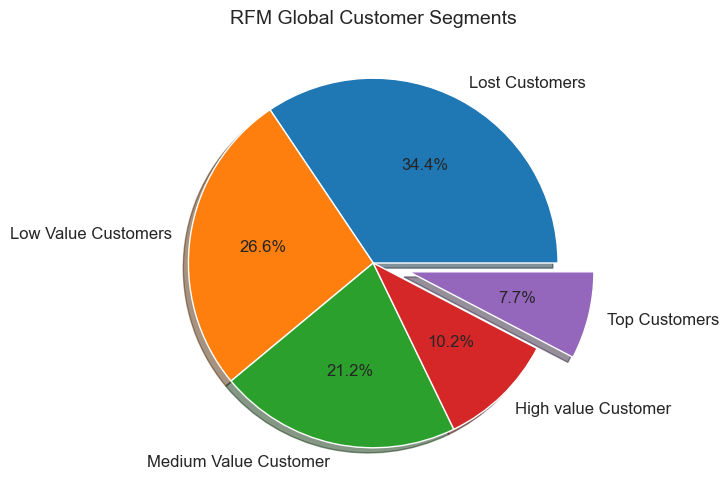

In [98]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(x=rfm_df_global.Customer_segment.value_counts().values, 
       labels=rfm_df_global.Customer_segment.value_counts().index, 
       autopct='%.1f%%',
       explode=[0,0,0,0,0.2],
       textprops={'fontsize': 12},
       shadow=True
       )
plt.title("RFM Global Customer Segments", fontdict = {'fontsize': 14})
plt.show()

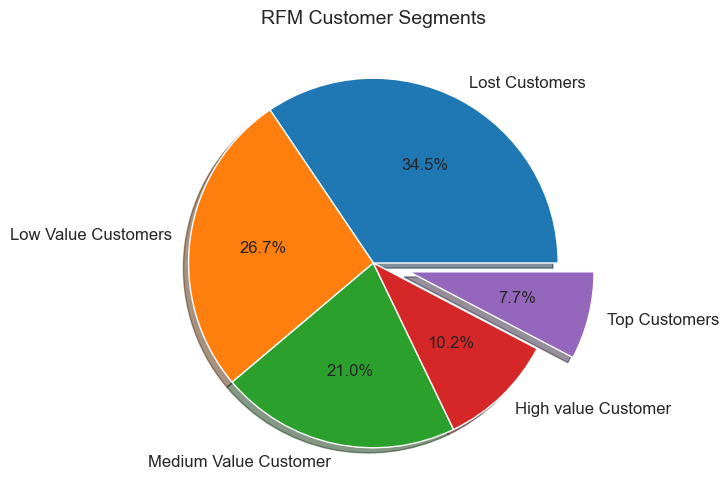

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(x=rfm_df.Customer_segment.value_counts().values, 
       labels=rfm_df.Customer_segment.value_counts().index, 
       autopct='%.1f%%',
       explode=[0,0,0,0,0.2],
       textprops={'fontsize': 12},
       shadow=True
       )
plt.title("RFM Customer Segments", fontdict = {'fontsize': 14})
plt.show()

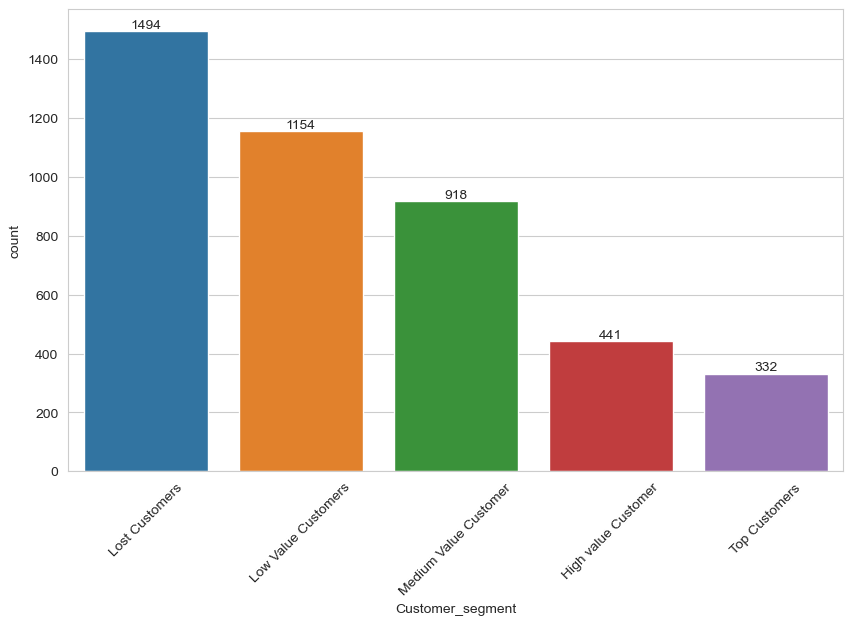

In [100]:
fig, ax = plt.subplots()

ax = sns.countplot(rfm_df_global.Customer_segment, order=rfm_df_global.Customer_segment.value_counts().index)

plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container);

In [101]:
rfm_df.Customer_segment.value_counts()

Lost Customers           1351
Low Value Customers      1047
Medium Value Customer     823
High value Customer       399
Top Customers             301
Name: Customer_segment, dtype: int64

In [102]:
rfm_df_global.Customer_segment.value_counts()

Lost Customers           1494
Low Value Customers      1154
Medium Value Customer     918
High value Customer       441
Top Customers             332
Name: Customer_segment, dtype: int64

# 3. Applying K-Means Clustering

Now that we have our customers segmented into different categories, we can gain further insight into customer behavior by using predictive models in conjuction with out RFM model.
Possible algorithms include **Logistic Regression**, **K-means Clustering**, and **K-nearest Neighbor**. We will go with [K-Means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) since we already have our distinct groups determined. K-means has also been widely used for market segmentation and has the advantage of being simple to implement.

## Data Pre-Processing and Exploring

### i. Define and Plot Feature Correlations

Create Heatmap and evaluate the results 

### ii. Visualize Feature Distributions

To get a better understanding of the dataset, you can costruct a scatter matrix of each of the three features in the RFM data.

### iii. Data Normalization

1. Logarithmic Tranformation can be used to normalize the values in a column.
2. Plot normalized data with scatter matrix or pairplot. Also evaluate results.

## K-Means Implementation

For k-means, you have to set k to the number of clusters you want, but figuring out how many clusters is not obvious from the beginning. We will try different cluster numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). 
<br>
<br>
**Note**: K-means is sensitive to initializations because they are critical to qualifty of optima found. Thus, we will use smart initialization called "Elbow Method".

### i. Define the Optimal Number of Clusters

[The Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) 

[Silhouette Coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

### ii. Model Fitting

Fit the K-Means Algorithm with the optimal number of clusters you decided and save the model to disk.

### iii. Visualize the Clusters

1. Create a scatter plot and select cluster centers

2. Visualize Cluster Id vs Recency, Cluster Id vs Frequency and Cluster Id vs Monetary using Box plot. Also evaluate the results. 

### iv. Assign the Label

### v. Conclusion

Discuss your final results. Compare your own labels from the RFM Customer Segmentation with the labels found by K-Means.

How we want to continue this analysis depends on how the business plans to use the results and the level of granularity the business stakeholders want to see in the clusters. We can also ask what range of customer behavior from high to low value customers are the stakeholders interested in exploring. From those answers, various methods of clustering can be used and applied on RFM variable or directly on the transaction data set.

**Annotation:**

Limitations of K-means clustering:

1. There is no assurance that it will lead to the global best solution.
2. Can't deal with different shapes(not circular) and consider one point's probability of belonging to more than one cluster.

These disadvantages of K-means show that for many datasets (especially low-dimensional datasets), it may not perform as well as you might hope.

**Conclusion**

* Write down your conclusions about clustering 

# 5. Create Cohort & Conduct Cohort Analysis
[Cohort Analysis](https://medium.com/swlh/cohort-analysis-using-python-and-pandas-d2a60f4d0a4d) is specifically useful in analyzing user growth patterns for products. In terms of a product, a cohort can be a group of people with the same sign-up date, the same usage starts month/date, or the same traffic source.
Cohort analysis is an analytics method by which these groups can be tracked over time for finding key insights. This analysis can further be used to do customer segmentation and track metrics like retention, churn, and lifetime value.

For e-commerce organizations, cohort analysis is a unique opportunity to find out which clients are the most valuable to their business. by performing Cohort analysis you can get the following answers to the following questions:

- How much effective was a marketing campaign held in a particular time period?
- Did the strategy employ to improve the conversion rates of Customers worked?
- Should I focus more on retention rather than acquiring new customers?
- Are my customer nurturing strategies effective?
- Which marketing channels bring me the best results?
- Is there a seasonality pattern in Customer behavior?
- Along with various performance measures/metrics for your organization.

Since we will be performing Cohort Analysis based on transaction records of customers, the columns we will be dealing with mainly:
- Invoice Data
- CustomerID
- Price
- Quantity

The following steps will performed to generate the Cohort Chart of Retention Rate:
- Month Extraction from InvioceDate column
- Assigning Cohort to Each Transaction
- Assigning Cohort Index to each transaction
- Calculating number of unique customers in each Group of (ChortDate,Index)
- Creating Cohort Table for Retention Rate
- Creating the Cohort Chart using the Cohort Table

The Detailed information about each step is given below:

## Future Engineering

### i. Extract the Month of the Purchase
First we will create a function, which takes any date and returns the formatted date with day value as 1st of the same month and Year.

In [103]:
df = pd.read_csv("df_cleaned.csv")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.850,12680.000,France
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.100,12680.000,France
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.150,12680.000,France
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.150,12680.000,France


In [104]:
df['Total'] = df['UnitPrice'] * df['Quantity']

In [105]:
import datetime as dt
def get_month(x) : return dt.datetime(x.year,x.month,1)

Now we will use the function created above to convert all the invoice dates into respective month date format.

In [106]:
df['InvoiceMonth'] = pd.to_datetime(df_global["InvoiceDate"]).apply(get_month)
df['InvoiceMonth']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
392727   2011-12-01
392728   2011-12-01
392729   2011-12-01
392730   2011-12-01
392731   2011-12-01
Name: InvoiceMonth, Length: 392732, dtype: datetime64[ns]

In [107]:
df.groupby('CustomerID')['CustomerID','InvoiceMonth'].head(10)
#.transform('min')

,CustomerID,InvoiceMonth
0,17850.000,2010-12-01
1,17850.000,2010-12-01
2,17850.000,2010-12-01
3,17850.000,2010-12-01
4,17850.000,2010-12-01
...,...,...
392596,12713.000,2011-12-01
392597,12713.000,2011-12-01
392598,12713.000,2011-12-01
392599,12713.000,2011-12-01


In [108]:
df["cohort_month"]= df.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [109]:
df.sample(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,InvoiceMonth,cohort_month
32532,540855,79321,CHILLI LIGHTS,72,2011-01-12 10:14:00,4.250,16353.000,United Kingdom,306.000,2011-01-01,2010-12-01
106674,550302,22501,PICNIC BASKET WICKER LARGE,2,2011-04-17 10:17:00,9.950,14156.000,EIRE,19.900,2011-04-01,2010-12-01
265352,569246,22129,PARTY CONES CANDY DECORATION,5,2011-10-03 09:57:00,2.460,14096.000,United Kingdom,12.300,2011-10-01,2011-08-01
130905,553417,23162,REGENCY TEA STRAINER,4,2011-05-17 10:08:00,3.750,13871.000,United Kingdom,15.000,2011-05-01,2011-02-01
247998,567656,21916,SET 12 RETRO WHITE CHALK STICKS,1,2011-09-21 14:40:00,0.830,14096.000,United Kingdom,0.830,2011-09-01,2011-08-01
152727,556257,20840,FRENCH FLORAL CUSHION COVER,24,2011-06-09 17:47:00,0.850,17576.000,United Kingdom,20.400,2011-06-01,2010-12-01
215323,563928,82552,WASHROOM METAL SIGN,1,2011-08-21 15:17:00,1.450,17059.000,United Kingdom,1.450,2011-08-01,2010-12-01
253155,568137,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-09-25 10:34:00,2.100,12488.000,France,12.600,2011-09-01,2011-09-01
389112,581171,22029,SPACEBOY BIRTHDAY CARD,12,2011-12-07 15:02:00,0.420,12615.000,France,5.040,2011-12-01,2011-06-01
370726,579196,48194,DOORMAT HEARTS,2,2011-11-28 15:54:00,15.790,14096.000,United Kingdom,31.580,2011-11-01,2011-08-01


In [110]:
df["InvoiceMonth"].describe()

count                  392732
unique                     13
top       2011-11-01 00:00:00
freq                    63182
first     2010-12-01 00:00:00
last      2011-12-01 00:00:00
Name: InvoiceMonth, dtype: object

### ii. Calculating time offset in Months i.e. Cohort Index:
Calculating time offset for each transaction will allows us to report the metrics for each cohort in a comparable fashion.
First, you will create 4 variables that capture the integer value of years, months for Invoice and Cohort Date using the get_date_int() function which you'll create it below.

In [111]:
def date_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

You will use this function to extract the integer values for Invoice as well as Cohort Date in 3 separate series for each of the two columns

In [112]:
invoice_year_int ,invoice_month_int, _ = date_int(df,'InvoiceMonth')
cohort_year_int ,cohort_month_int, _ = date_int(df,'cohort_month')

In [113]:
invoice_month_int

0         12
1         12
2         12
3         12
4         12
          ..
392727    12
392728    12
392729    12
392730    12
392731    12
Name: InvoiceMonth, Length: 392732, dtype: int64

Use the variables created above to calcualte the difference in days and store them in cohort Index column.

In [114]:
year_diff = invoice_year_int - cohort_year_int
month_diff = invoice_month_int - cohort_month_int

month_diff.value_counts(dropna=False)

 0     124041
-1      21681
 2      18040
 1      17405
 3      15873
 4      15538
 5      14730
-3      14099
-2      13399
 6      12393
 7      11986
-7      11946
 8      11440
-4      11322
-5      11312
-9      11122
-6      11069
-11     10114
-8       9628
 9       8870
-10      8689
 10      6701
 11      1334
dtype: int64

In [115]:
year_diff.value_counts(dropna=False)

0    251178
1    141554
dtype: int64

In [116]:
df['cohort_index'] = year_diff * 12 + month_diff + 1 
df.sample(8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,InvoiceMonth,cohort_month,cohort_index
32465,540839,21531,RED RETROSPOT SUGAR JAM BOWL,4,2011-01-11 15:42:00,2.550,16791.000,United Kingdom,10.200,2011-01-01,2011-01-01,1
187008,560650,22726,ALARM CLOCK BAKELIKE GREEN,1,2011-07-20 11:38:00,3.750,15529.000,United Kingdom,3.750,2011-07-01,2010-12-01,8
137236,554124,21537,RED RETROSPOT PUDDING BOWL,4,2011-05-23 08:31:00,4.250,13339.000,United Kingdom,17.000,2011-05-01,2011-05-01,1
198464,562045,23308,SET OF 60 VINTAGE LEAF CAKE CASES,24,2011-08-02 10:33:00,0.550,12644.000,Germany,13.200,2011-08-01,2011-08-01,1
88871,547892,20719,WOODLAND CHARLOTTE BAG,10,2011-03-28 10:15:00,0.850,12669.000,France,8.500,2011-03-01,2011-03-01,1
184341,560305,23053,RECYCLED ACAPULCO MAT PINK,1,2011-07-18 10:49:00,8.250,16511.000,United Kingdom,8.250,2011-07-01,2011-03-01,5
240827,566850,22704,WRAP RED APPLES,25,2011-09-15 12:04:00,0.420,13662.000,United Kingdom,10.500,2011-09-01,2011-03-01,7
290544,571669,23520,EMBROIDERED RIBBON REEL RUBY,4,2011-10-18 13:11:00,3.750,17758.000,United Kingdom,15.000,2011-10-01,2011-04-01,7


In [117]:
df.cohort_index.value_counts()

1     116868
2      27519
4      26995
3      26729
6      26676
5      25166
7      23462
8      23298
12     23015
10     22969
9      22762
11     20100
13      7173
Name: cohort_index, dtype: int64

In [118]:
df["InvoiceMonth"].dt.date.unique()

array([datetime.date(2010, 12, 1), datetime.date(2011, 1, 1),
       datetime.date(2011, 2, 1), datetime.date(2011, 3, 1),
       datetime.date(2011, 4, 1), datetime.date(2011, 5, 1),
       datetime.date(2011, 6, 1), datetime.date(2011, 7, 1),
       datetime.date(2011, 8, 1), datetime.date(2011, 9, 1),
       datetime.date(2011, 10, 1), datetime.date(2011, 11, 1),
       datetime.date(2011, 12, 1)], dtype=object)

## Create 1st Cohort: User number & Retention Rate

### i. Pivot Cohort and Cohort Retention

In [119]:
df.groupby(by=['cohort_month', 'cohort_index']).head(1).sort_values('cohort_month').sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,InvoiceMonth,cohort_month,cohort_index
264905,569232,15060B,FAIRY CAKE DESIGN UMBRELLA,3,2011-10-02 15:26:00,3.750,16667.000,United Kingdom,11.250,2011-10-01,2011-02-01,9
66416,545222,22957,SET 3 PAPER VINTAGE CHICK PAPER EGG,6,2011-03-01 08:49:00,2.950,13880.000,United Kingdom,17.700,2011-03-01,2010-12-01,4
197562,561922,82486,WOOD S/3 CABINET ANT WHITE FINISH,2,2011-08-01 12:12:00,8.950,13167.000,United Kingdom,17.900,2011-08-01,2011-07-01,2
263728,569203,79321,CHILLI LIGHTS,48,2011-10-02 10:32:00,4.950,16353.000,United Kingdom,237.600,2011-10-01,2010-12-01,11
116381,551564,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-05-03 10:56:00,4.150,16609.000,United Kingdom,16.600,2011-05-01,2011-04-01,2


In [120]:
df.groupby(by=['cohort_month', 'cohort_index'])[["CustomerID"]].nunique()

CustomerID
cohort_month cohort_index            
2010-12-01   1                    885
             2                    324
             3                    286
             4                    340
             5                    321
             6                    352
             7                    321
             8                    309
             9                    313
             10                   350
             11                   331
             12                   445
             13                   235
2011-01-01   1                    417
             2                     92
             3                    111
             4                     96
             5                    134
             6                    120
             7                    103
             8                    101
             9                    125
             10                   136
             11                   152
             12                    49
2011-02-01   1                    380
             2                     71
             3                     71
             4                    108
             5                    103
             6                     94
             7                     96
             8                    106
             9                     94
             10                   116
             11                    26
2011-03-01   1                    452
             2                     68
             3                    114
             4                     90
             5                    101
             6                     76
             7                    121
             8                    104
             9                    126
             10                    39
2011-04-01   1                    300
             2                     64
             3                     61
             4                     63
             5                     59
             6                     68
             7                     65
             8                     78
             9                     22
2011-05-01   1                    284
             2                     54
             3                     49
             4                     49
             5                     59
             6                     66
             7                     75
             8                     27
2011-06-01   1                    242
             2                     42
             3                     38
             4                     64
             5                     56
             6                     81
             7                     23
2011-07-01   1                    188
             2                     34
             3                     39
             4                     42
             5                     51
             6                     21
2011-08-01   1                    169
             2                     35
             3                     42
             4                     41
             5                     21
2011-09-01   1                    299
             2                     70
             3                     90
             4                     34
2011-10-01   1                    358
             2                     86
             3                     41
2011-11-01   1                    324
             2                     36
2011-12-01   1                     41

In [121]:
cohort_cust_num= df.groupby(by=['cohort_month', 'cohort_index'])[["CustomerID"]].nunique().\
    reset_index().rename(columns={"CustomerID": "Number_of_Customers"})
cohort_cust_num

,cohort_month,cohort_index,Number_of_Customers
0,2010-12-01,1,885
1,2010-12-01,2,324
2,2010-12-01,3,286
3,2010-12-01,4,340
4,2010-12-01,5,321
5,2010-12-01,6,352
6,2010-12-01,7,321
7,2010-12-01,8,309
8,2010-12-01,9,313
9,2010-12-01,10,350


In [122]:
cohort_cust_num = cohort_cust_num.pivot(index='cohort_month',columns='cohort_index', values="Number_of_Customers")
cohort_cust_num

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,885.000,324.000,286.000,340.000,321.000,352.000,321.000,309.000,313.000,350.000,331.000,445.000,235.000
2011-01-01,417.000,92.000,111.000,96.000,134.000,120.000,103.000,101.000,125.000,136.000,152.000,49.000,NaN
2011-02-01,380.000,71.000,71.000,108.000,103.000,94.000,96.000,106.000,94.000,116.000,26.000,NaN,NaN
2011-03-01,452.000,68.000,114.000,90.000,101.000,76.000,121.000,104.000,126.000,39.000,NaN,NaN,NaN
2011-04-01,300.000,64.000,61.000,63.000,59.000,68.000,65.000,78.000,22.000,NaN,NaN,NaN,NaN
2011-05-01,284.000,54.000,49.000,49.000,59.000,66.000,75.000,27.000,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.000,42.000,38.000,64.000,56.000,81.000,23.000,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.000,34.000,39.000,42.000,51.000,21.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.000,35.000,42.000,41.000,21.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ii. Visualize analysis of cohort 1 using seaborn and matplotlib modules

In [123]:
cohort_cust_num.index, cohort_cust_num.columns

(DatetimeIndex(['2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
                '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
                '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
                '2011-12-01'],
               dtype='datetime64[ns]', name='cohort_month', freq=None),
 Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64', name='cohort_index'))

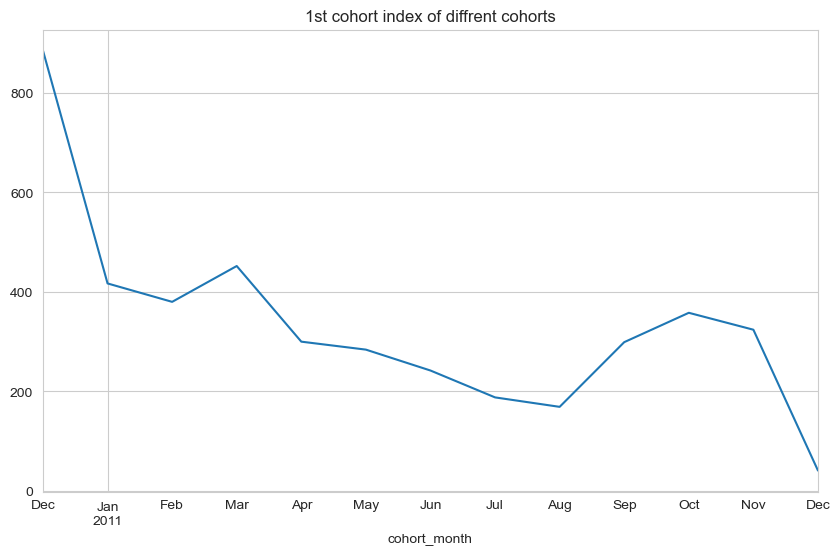

In [124]:
cohort_cust_num[1].plot(kind="line",title="1st cohort index of diffrent cohorts");

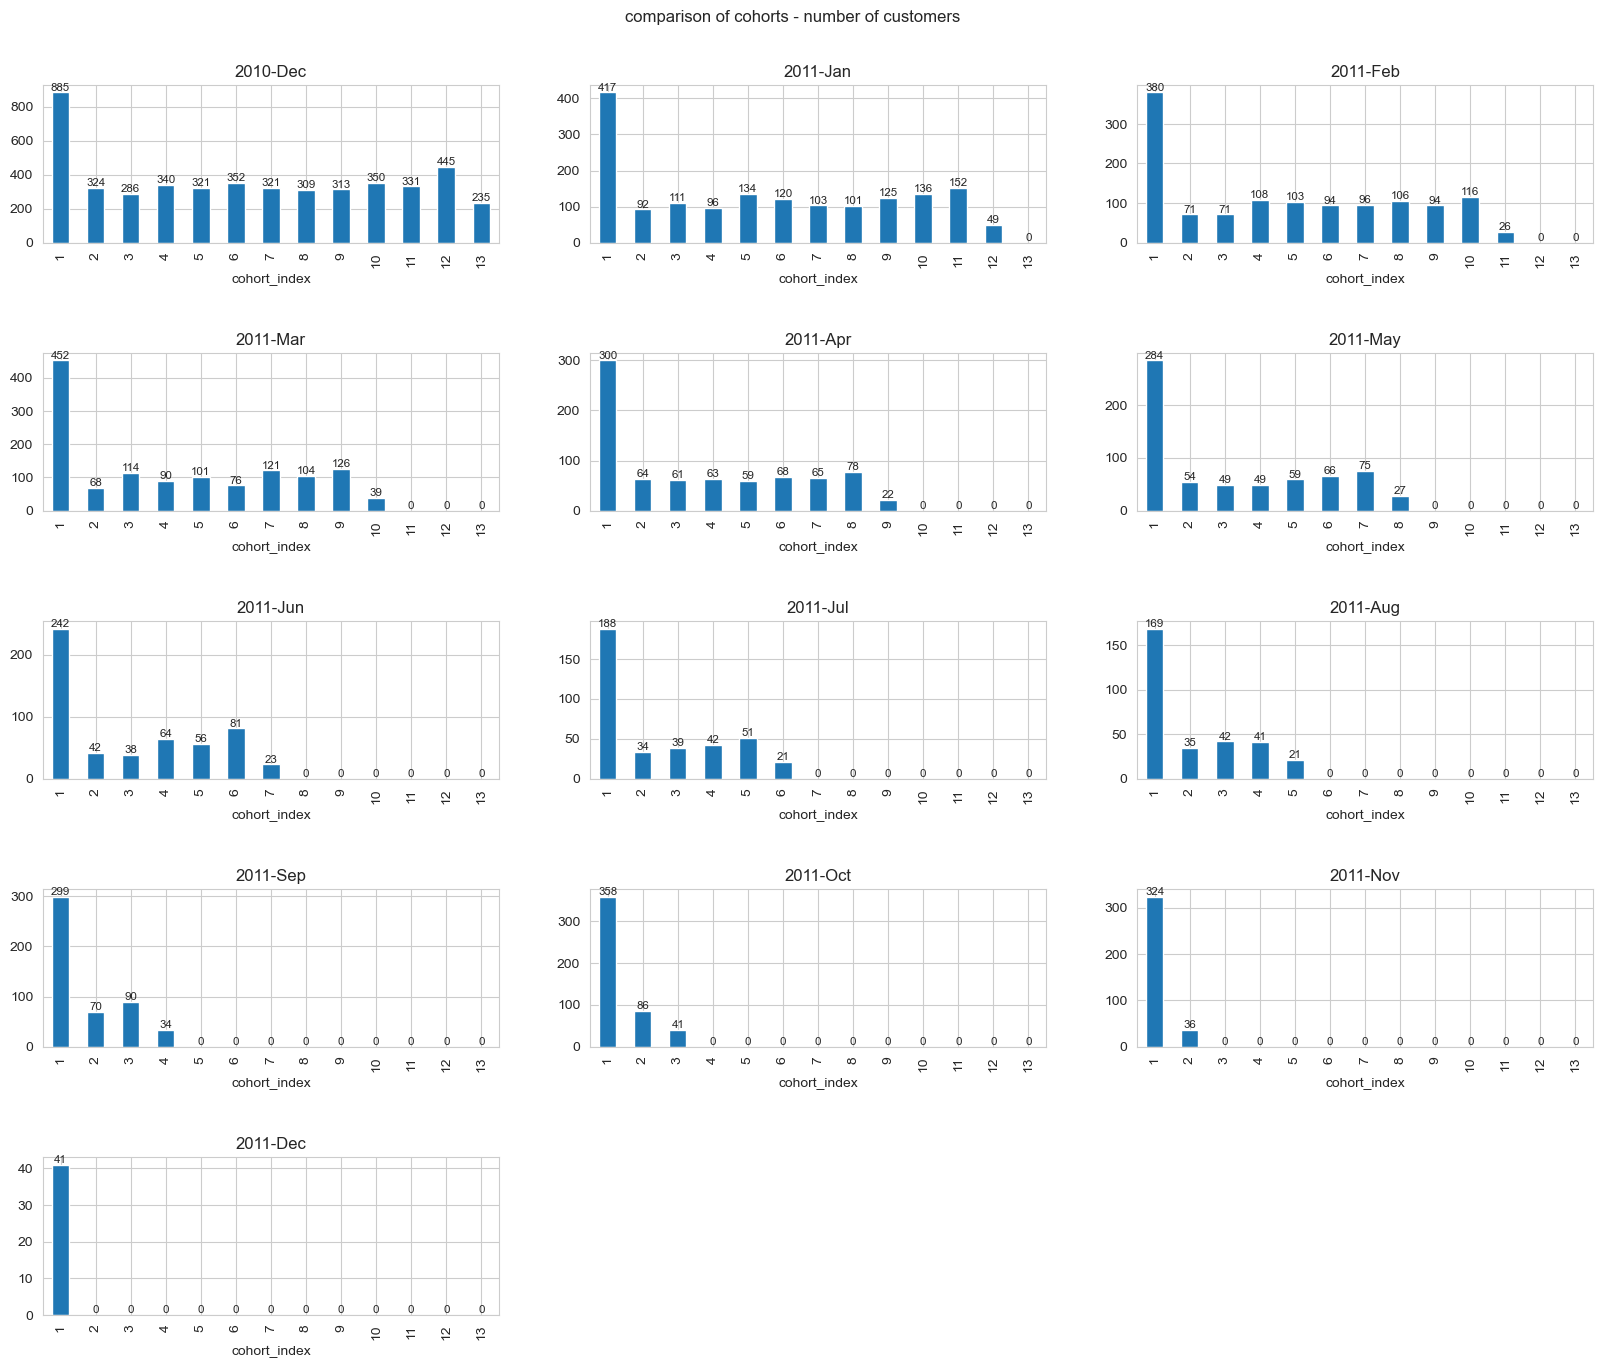

In [125]:
plt.figure(figsize=(20,15))
plt.suptitle("comparison of cohorts - number of customers")


for i in range(len(cohort_cust_num)):
    title = cohort_cust_num.index[i].strftime("%Y-%b")
    plt.subplot(5,3,i+1)
    ax = cohort_cust_num.iloc[i].plot(kind="bar", title= title)
    ax.bar_label(ax.containers[0], fontsize="small")
    plt.subplots_adjust(top=0.93, hspace=0.7)

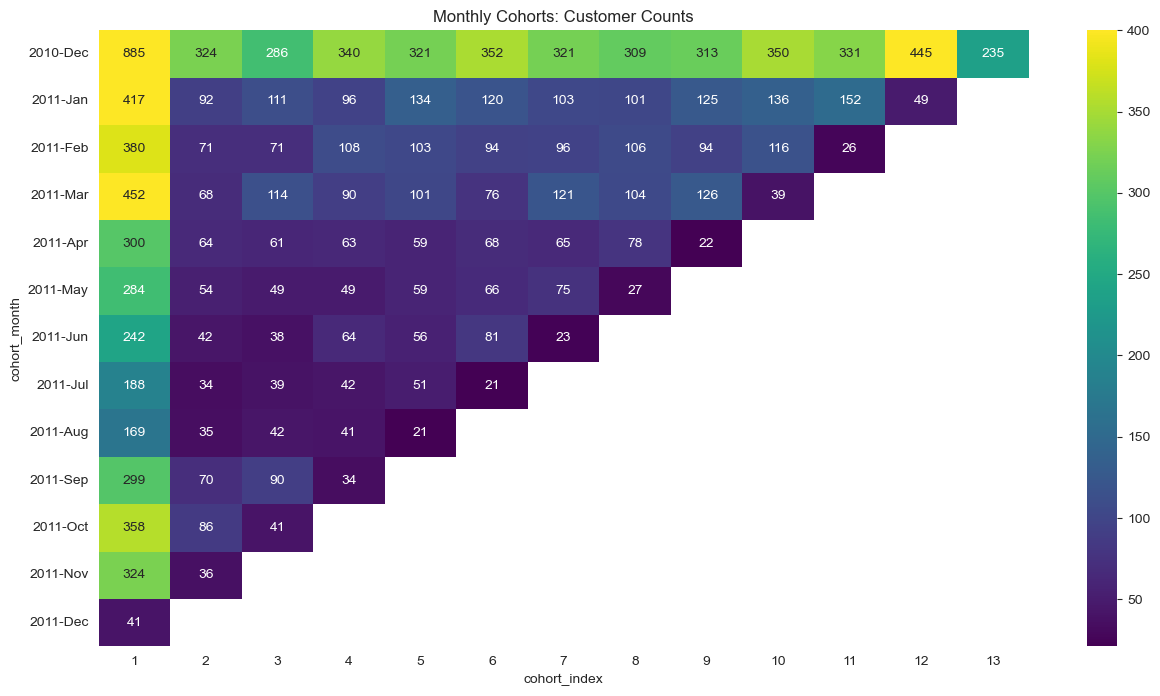

In [126]:
ylabels = cohort_cust_num.index.strftime('%Y-%b')

plt.figure(figsize=(15, 8))
plt.title('Monthly Cohorts: Customer Counts')
sns.heatmap(data=cohort_cust_num,annot = True, vmax =400, fmt='.0f',
            yticklabels=ylabels, 
            cmap='viridis')
plt.show()

In [127]:
cohort_retention_df = (cohort_cust_num.divide(cohort_cust_num.iloc[:,0], axis=0)).round(1)
cohort_retention_df

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,1.000,0.400,0.300,0.400,0.400,0.400,0.400,0.300,0.400,0.400,0.400,0.500,0.300
2011-01-01,1.000,0.200,0.300,0.200,0.300,0.300,0.200,0.200,0.300,0.300,0.400,0.100,NaN
2011-02-01,1.000,0.200,0.200,0.300,0.300,0.200,0.300,0.300,0.200,0.300,0.100,NaN,NaN
2011-03-01,1.000,0.200,0.300,0.200,0.200,0.200,0.300,0.200,0.300,0.100,NaN,NaN,NaN
2011-04-01,1.000,0.200,0.200,0.200,0.200,0.200,0.200,0.300,0.100,NaN,NaN,NaN,NaN
2011-05-01,1.000,0.200,0.200,0.200,0.200,0.200,0.300,0.100,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.000,0.200,0.200,0.300,0.200,0.300,0.100,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.000,0.200,0.200,0.200,0.300,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.000,0.200,0.200,0.200,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


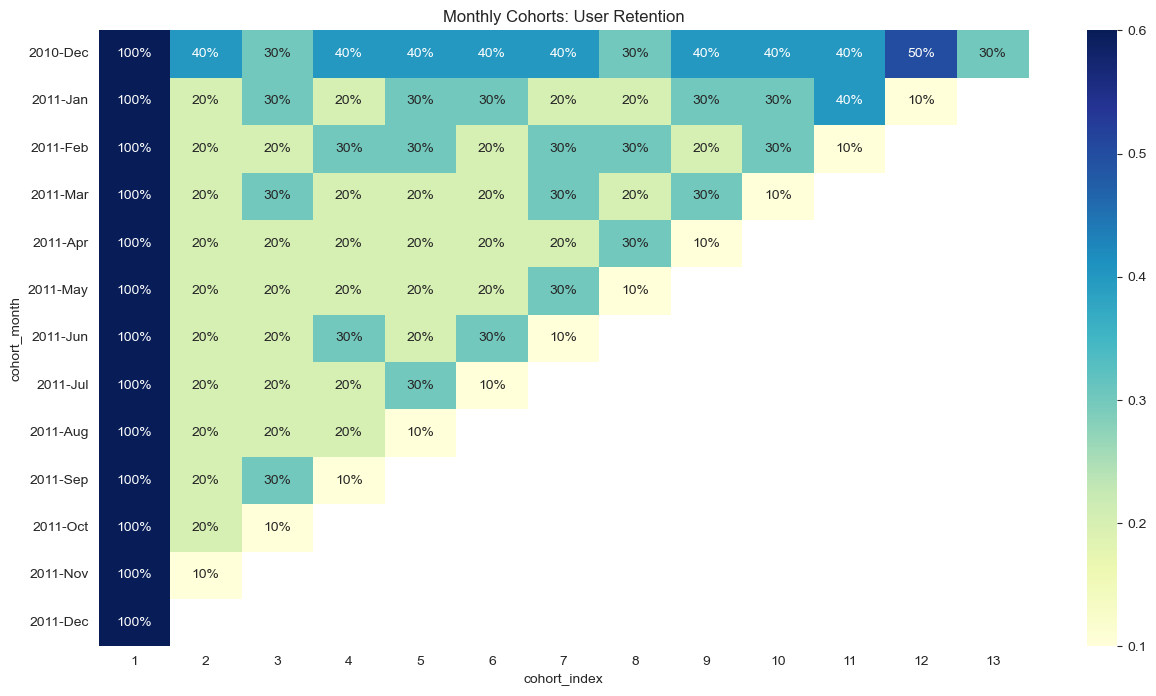

In [128]:
ylabels = cohort_retention_df.index.strftime('%Y-%b')

plt.figure(figsize=(15, 8))
plt.title('Monthly Cohorts: User Retention')
sns.heatmap(data=cohort_retention_df,annot = True, vmax = 0.6, fmt = '.0%',
            yticklabels=ylabels, 
            cmap='YlGnBu')
plt.show()

## Create the 2nd Cohort: Average Quantity Sold

### i. Pivot Cohort and Cohort Retention

In [129]:
df.groupby(by=['cohort_month', 'cohort_index'])[["Quantity"]].mean().reset_index().round(0)

,cohort_month,cohort_index,Quantity
0,2010-12-01,1,12.000
1,2010-12-01,2,16.000
2,2010-12-01,3,16.000
3,2010-12-01,4,16.000
4,2010-12-01,5,14.000
5,2010-12-01,6,15.000
6,2010-12-01,7,16.000
7,2010-12-01,8,16.000
8,2010-12-01,9,18.000
9,2010-12-01,10,18.000


In [130]:
cohort_avg_quantity = df.groupby(by=['cohort_month', 'cohort_index'])[["Quantity"]].mean().reset_index().round(0)
cohort_avg_quantity = cohort_avg_quantity.pivot(index='cohort_month',columns='cohort_index', values="Quantity")
cohort_avg_quantity = cohort_avg_quantity.astype('Int64')
cohort_avg_quantity

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,12,16,16,16,14,15,16,16,18,18,19,14,15
2011-01-01,17,13,13,15,13,15,15,15,12,11,10,10,<NA>
2011-02-01,11,14,19,12,12,12,14,13,11,12,13,<NA>,<NA>
2011-03-01,10,12,13,10,14,13,13,14,11,10,<NA>,<NA>,<NA>
2011-04-01,10,10,10,12,12,9,10,10,8,<NA>,<NA>,<NA>,<NA>
2011-05-01,11,10,14,13,11,9,11,114,<NA>,<NA>,<NA>,<NA>,<NA>
2011-06-01,11,15,11,14,11,10,10,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-07-01,10,14,7,8,6,7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-08-01,10,6,5,6,7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### ii. Visualize analysis of cohort 2 using seaborn and matplotlib modules

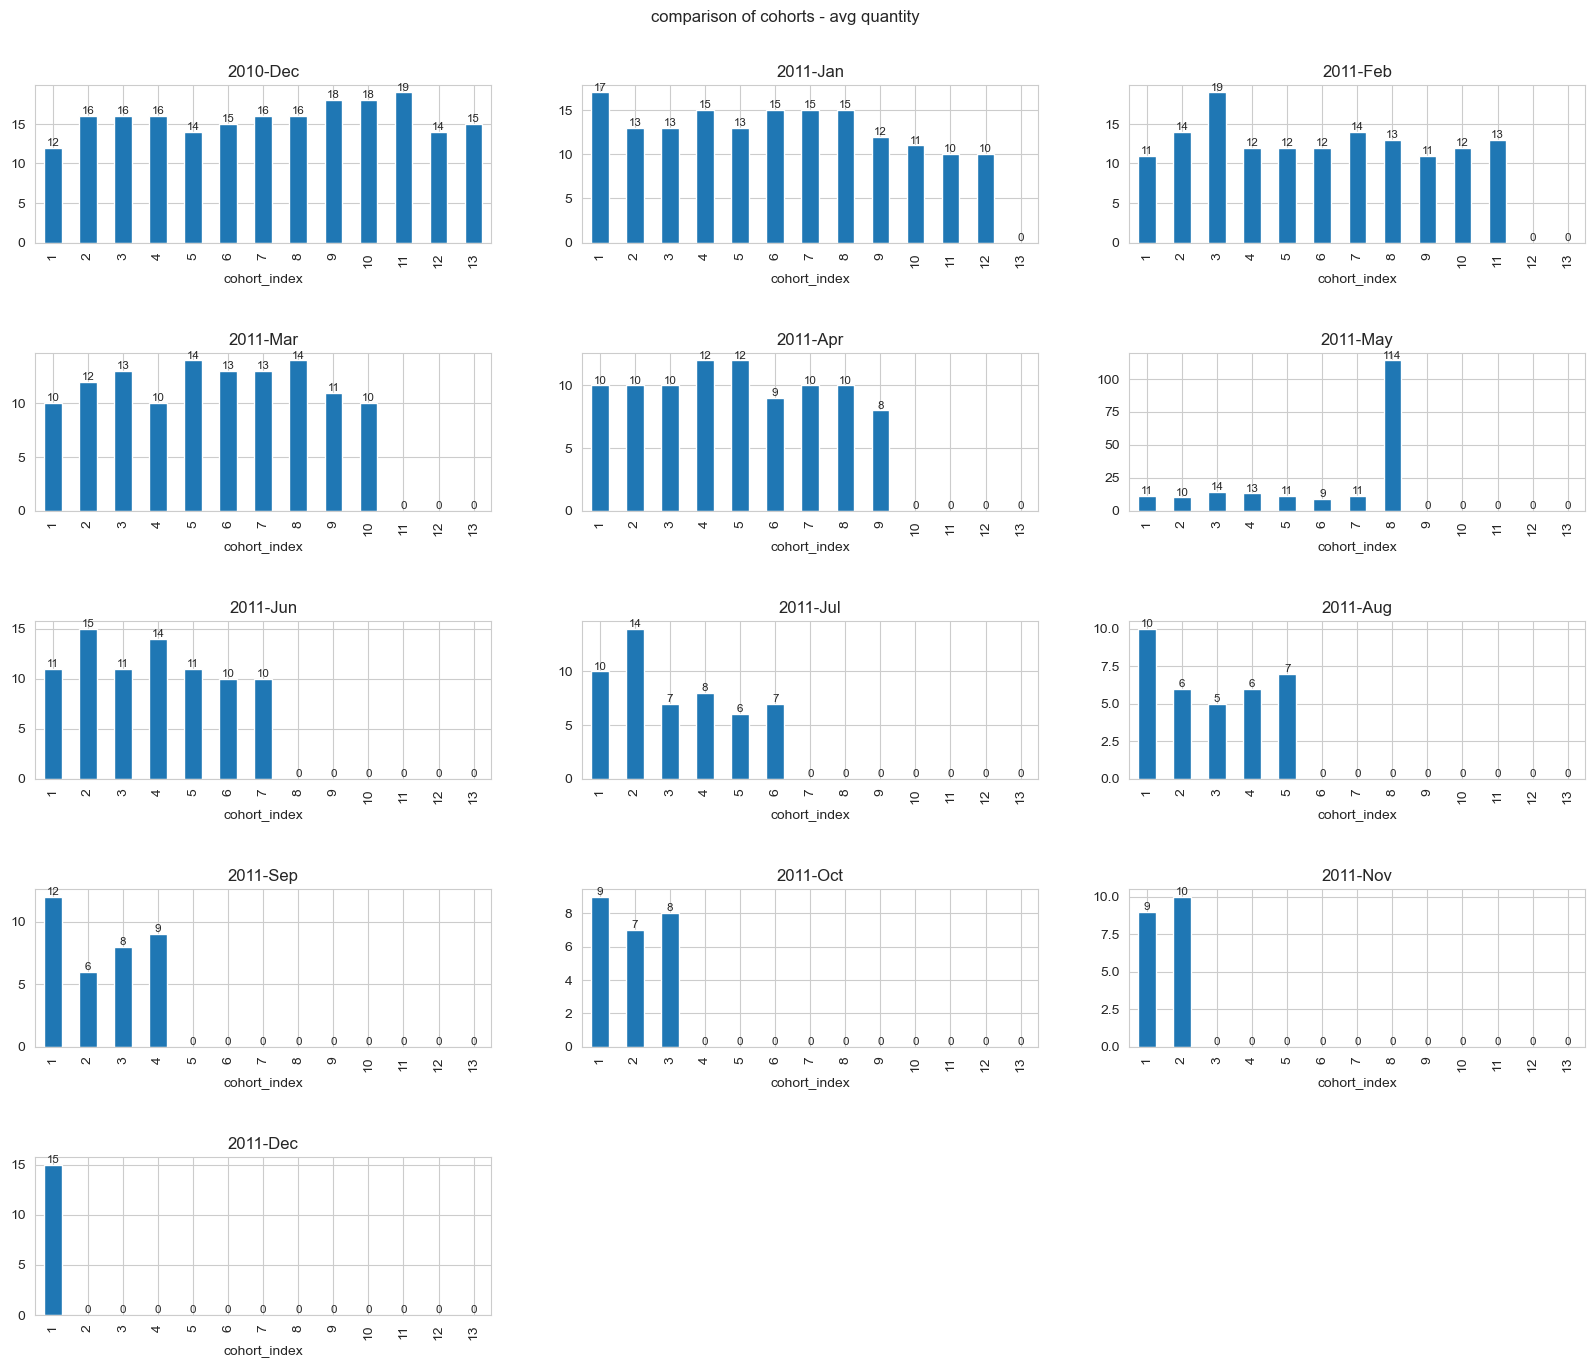

In [131]:
plt.figure(figsize=(20,15))
plt.suptitle("comparison of cohorts - avg quantity")

for i in range(len(cohort_avg_quantity)):
    title=cohort_avg_quantity.index[i].strftime("%Y-%b")
    plt.subplot(5,3,i+1)
    ax = cohort_avg_quantity.iloc[i].plot(kind="bar", title= title)
    ax.bar_label(ax.containers[0], fontsize="small")
    plt.subplots_adjust(top=0.93, hspace=0.7)

In [132]:
cohort_avg_quantity_retention = (cohort_avg_quantity.divide(cohort_avg_quantity.iloc[:,0], axis=0)).round(1)
cohort_avg_quantity_retention

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,1.000,1.300,1.300,1.300,1.200,1.200,1.300,1.300,1.500,1.500,1.600,1.200,1.200
2011-01-01,1.000,0.800,0.800,0.900,0.800,0.900,0.900,0.900,0.700,0.600,0.600,0.600,<NA>
2011-02-01,1.000,1.300,1.700,1.100,1.100,1.100,1.300,1.200,1.000,1.100,1.200,<NA>,<NA>
2011-03-01,1.000,1.200,1.300,1.000,1.400,1.300,1.300,1.400,1.100,1.000,<NA>,<NA>,<NA>
2011-04-01,1.000,1.000,1.000,1.200,1.200,0.900,1.000,1.000,0.800,<NA>,<NA>,<NA>,<NA>
2011-05-01,1.000,0.900,1.300,1.200,1.000,0.800,1.000,10.400,<NA>,<NA>,<NA>,<NA>,<NA>
2011-06-01,1.000,1.400,1.000,1.300,1.000,0.900,0.900,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-07-01,1.000,1.400,0.700,0.800,0.600,0.700,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-08-01,1.000,0.600,0.500,0.600,0.700,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


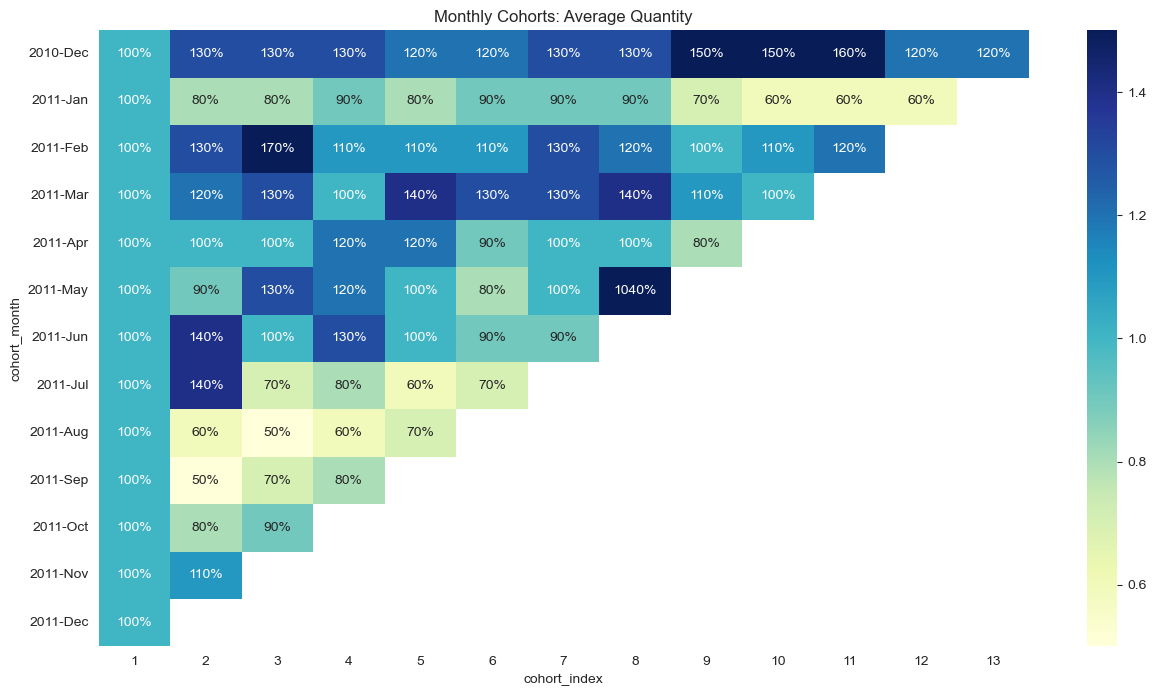

In [133]:
cohort_avg_quantity_retention = cohort_avg_quantity_retention[cohort_avg_quantity_retention.columns].astype(float)

ylabels = cohort_avg_quantity_retention.index.strftime('%Y-%b')

plt.figure(figsize=(15, 8))
plt.title('Monthly Cohorts: Average Quantity')
sns.heatmap(data=cohort_avg_quantity_retention, annot = True, vmax = 1.5, fmt = '.0%',
            yticklabels=ylabels, 
            cmap='YlGnBu');

## Create the 3rd Cohort: Average Sales


### i. Pivot Cohort and Cohort Retention

In [134]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total', 'InvoiceMonth',
       'cohort_month', 'cohort_index'],
      dtype='object')

In [135]:
df.groupby(by=['cohort_month', 'cohort_index'])[["Total"]].mean().reset_index().round(0)

,cohort_month,cohort_index,Total
0,2010-12-01,1,22.000
1,2010-12-01,2,27.000
2,2010-12-01,3,27.000
3,2010-12-01,4,27.000
4,2010-12-01,5,21.000
5,2010-12-01,6,28.000
6,2010-12-01,7,28.000
7,2010-12-01,8,27.000
8,2010-12-01,9,29.000
9,2010-12-01,10,33.000


In [136]:
cohort_avg_spend = df.groupby(by=['cohort_month', 'cohort_index'])[["Total"]].mean().reset_index().round(0)
cohort_avg_spend = cohort_avg_spend.pivot(index='cohort_month',columns='cohort_index', values="Total")
cohort_avg_spend = cohort_avg_spend.astype('Int64')
cohort_avg_spend

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,22,27,27,27,21,28,28,27,29,33,34,24,26
2011-01-01,27,25,21,31,22,26,25,25,19,22,20,20,<NA>
2011-02-01,18,21,21,19,18,17,22,23,19,22,24,<NA>,<NA>
2011-03-01,18,21,23,18,21,19,22,20,17,13,<NA>,<NA>,<NA>
2011-04-01,17,21,19,19,20,15,15,16,12,<NA>,<NA>,<NA>,<NA>
2011-05-01,20,17,22,21,19,14,17,235,<NA>,<NA>,<NA>,<NA>,<NA>
2011-06-01,24,16,20,20,15,17,13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-07-01,15,24,12,13,11,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-08-01,17,13,13,16,17,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### ii. Visualize analysis of cohort 3 using seaborn and matplotlib modules

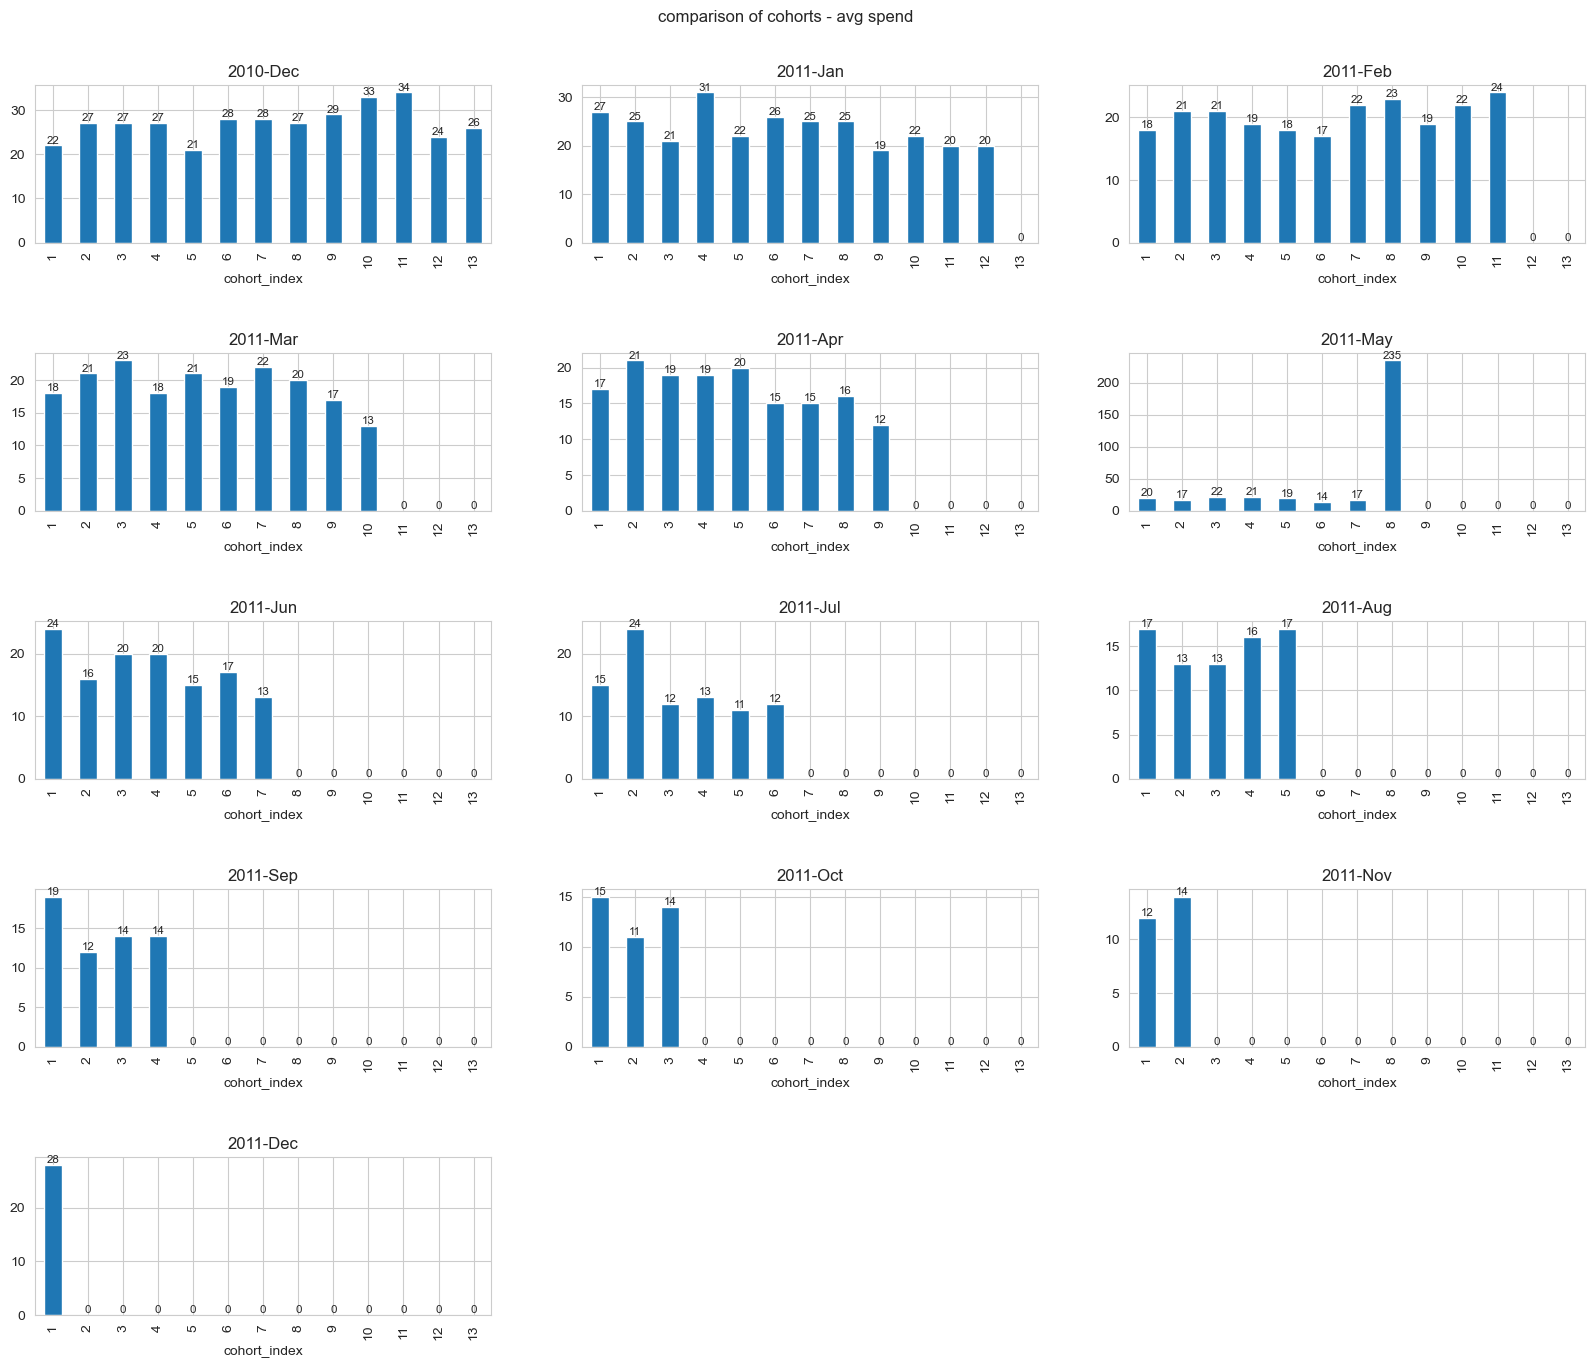

In [137]:
plt.figure(figsize=(20,15))
plt.suptitle("comparison of cohorts - avg spend")

for i in range(len(cohort_avg_spend)):
    title=cohort_avg_spend.index[i].strftime("%Y-%b")
    plt.subplot(5,3,i+1)
    ax = cohort_avg_spend.iloc[i].plot(kind="bar", title= title)
    ax.bar_label(ax.containers[0], fontsize="small")
    plt.subplots_adjust(top=0.93, hspace=0.7)

In [138]:
cohort_avg_spend_retention = (cohort_avg_spend.divide(cohort_avg_spend.iloc[:,0], axis=0)).round(1)
cohort_avg_spend_retention

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,1.000,1.200,1.200,1.200,1.000,1.300,1.300,1.200,1.300,1.500,1.500,1.100,1.200
2011-01-01,1.000,0.900,0.800,1.100,0.800,1.000,0.900,0.900,0.700,0.800,0.700,0.700,<NA>
2011-02-01,1.000,1.200,1.200,1.100,1.000,0.900,1.200,1.300,1.100,1.200,1.300,<NA>,<NA>
2011-03-01,1.000,1.200,1.300,1.000,1.200,1.100,1.200,1.100,0.900,0.700,<NA>,<NA>,<NA>
2011-04-01,1.000,1.200,1.100,1.100,1.200,0.900,0.900,0.900,0.700,<NA>,<NA>,<NA>,<NA>
2011-05-01,1.000,0.800,1.100,1.000,1.000,0.700,0.800,11.800,<NA>,<NA>,<NA>,<NA>,<NA>
2011-06-01,1.000,0.700,0.800,0.800,0.600,0.700,0.500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-07-01,1.000,1.600,0.800,0.900,0.700,0.800,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-08-01,1.000,0.800,0.800,0.900,1.000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


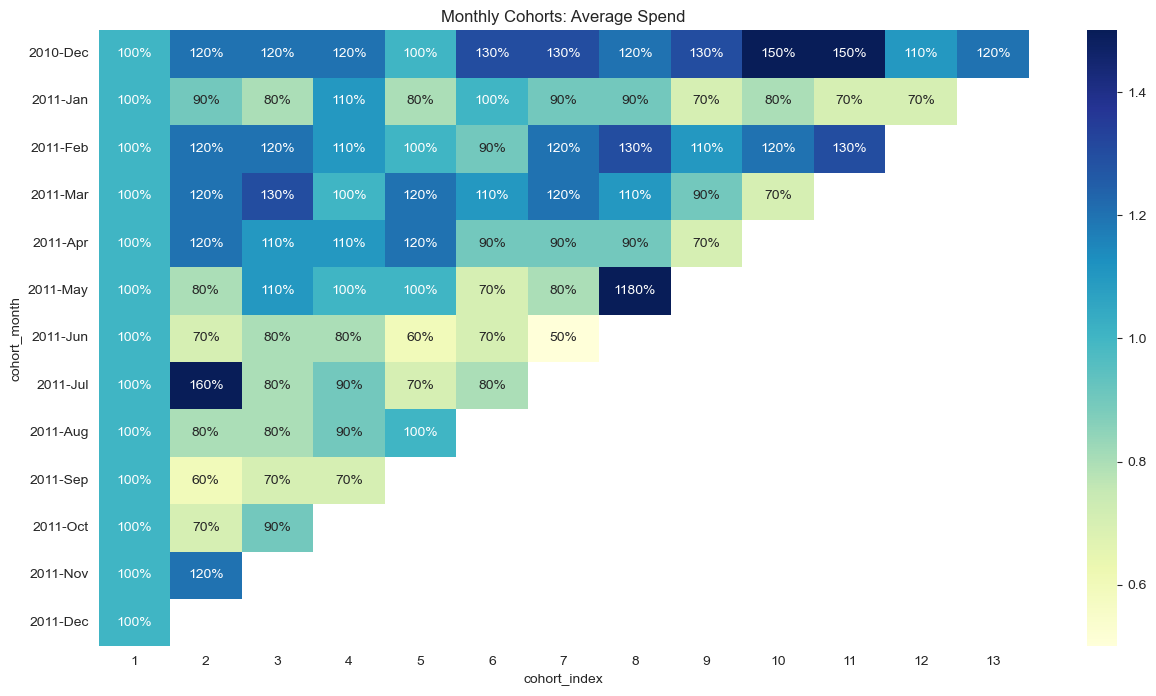

In [139]:
cohort_avg_spend_retention = cohort_avg_spend_retention[cohort_avg_spend_retention.columns].astype(float)

ylabels = cohort_avg_quantity_retention.index.strftime('%Y-%b')

plt.figure(figsize=(15, 8))
plt.title('Monthly Cohorts: Average Spend')
sns.heatmap(data=cohort_avg_spend_retention, annot = True, vmax = 1.5, fmt = '.0%',
            yticklabels=ylabels, 
            cmap='YlGnBu');

For e-commerce organisations, cohort analysis is a unique opportunity to find out which clients are the most valuable to their business. by performing Cohort analysis you can get answers to following questions:

- How much effective was a marketing campaign held in a particular time period?
- Did the strategy employed to improve the conversion rates of Customers worked?
- Should I focus more on retention rather than acquiring new customers?
- Are my customer nurturing strategies effective?
- Which marketing channels bring me the best results?
- Is there a seasoanlity pattern in Customer behahiour?